In [85]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = "Ubuntu"
plt.rcParams['font.weight'] = "light"
from matplotlib import ticker
from matplotlib import patheffects
import numpy as np
import seaborn as sns
import xarray as xr

import covid19

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

## data

In [111]:
#istat_path = 'comuni_giornaliero.csv'
#_, istat = covid19.data.read_istat(istat_path)

#istat_italy = istat.sel(year=2020).sum(['location', 'age_class'])
#istat_italy -= istat_italy.sel(time=slice(None, '2020-02-20')).mean()
#istat_italy = istat_italy.sel(time=slice(None, '2020-04-30'))
#istat_italy

In [384]:
# data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'

In [410]:
# data_italy_path = covid19.data.download('andamento-nazionale')
data_italy_regions_path = covid19.data.download('regioni')

In [411]:
ds_italy_regions = covid19.data.read_dpc(data_italy_regions_path)

# ds_italy_regions = ds_italy_regions.drop(dim='location', labels=['Italy / Lombardia'])

ds_italy_regions['daily_deaths'] = ds_italy_regions['deaths'].diff('time')

ds_italy_regions['daily_confirmed'] = ds_italy_regions['confirmed'].diff('time')
ds_italy_regions['daily_tests'] = ds_italy_regions['tests'].diff('time')
ds_italy_regions['daily_tested'] = ds_italy_regions['tested'].diff('time')

ds_italy_regions['daily_tpr'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['daily_tests']

ds_italy_regions['mortality'] = ds_italy_regions['deaths'] / ds_italy_regions['population'] * 1_000_000

ds_italy_regions['daily_mortality'] = ds_italy_regions['daily_deaths'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_prevalence'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tests_pm'] = ds_italy_regions['daily_tests'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tested_pm'] = ds_italy_regions['daily_tested'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_severe_pm'] = ds_italy_regions['current_severe'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_critical_pm'] = ds_italy_regions['current_critical'] / ds_italy_regions['population'] * 1_000_000

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm',]:
    ds_italy_regions[kind + '7'] = ds_italy_regions[kind].rolling({'time': 7}).mean()

for kind in ['daily_confirmed', 'daily_deaths', 'daily_mortality', 'daily_prevalence']:
    ds_italy_regions[kind + '14'] = ds_italy_regions[kind].rolling({'time': 14}).mean()

ds_italy_regions['daily_tpr7'] = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']

ds_italy_regions = ds_italy_regions.fillna(0)
ds_italy_regions = ds_italy_regions.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in ds_italy_regions.location.values])})
ds_italy_regions = ds_italy_regions.drop(['lat', 'lon', 'state_region', 'country'])

ds_italy_regions = ds_italy_regions.drop(['deaths', 'confirmed', 'tests', 'tested', 'mortality'])

# ds_italy_regions = ds_italy_regions.sel(time=slice(None, '2020-07-20'))

In [412]:
tmp = ds_italy_regions.sortby(-ds_italy_regions['current_critical_pm'].isel(time=-1)).isel(time=-1)
REGIONS = list(tmp.location.astype(str).values)
tmp.to_dataframe()  # [['daily_prevalence', 'daily_tpr']]

current_severe  current_critical  current_confirmed  \
location                                                                     
Marche                            806               147              10004   
Emilia-Romagna                   3442               401              72754   
Lombardia                        7069               868             102691   
Piemonte                         3776               369              35575   
P.A. Trento                       206                45               3185   
Toscana                          1505               264              27561   
Friuli Venezia Giulia             662                84              15626   
Umbria                            365                60               5063   
Valle d'Aosta                      37                 8                820   
Lazio                            2881               370              51436   
Puglia                           1800               238              46880   
Abruzzo                           613                77              10666   
Veneto                           1576               267              39649   
Molise                             73                16               1027   
P.A. Bolzano                       94                25                870   
Liguria                           636                67               6751   
Campania                         1592               165              96662   
Sicilia                           844               129              17000   
Basilicata                        158                13               4808   
Calabria                          377                36              10302   
Sardegna                          189                30              13905   

                       population  daily_deaths  daily_confirmed  daily_tests  \
location                                                                        
Marche                    1538055          12.0            505.0       4661.0   
Emilia-Romagna            4448841          31.0           2132.0      19056.0   
Lombardia                10018806          75.0           3520.0      43334.0   
Piemonte                  4392526          10.0           1543.0      15870.0   
P.A. Trento                538604           1.0            162.0       2590.0   
Toscana                   3742437          27.0           1368.0      22443.0   
Friuli Venezia Giulia     1217872          23.0            446.0       6767.0   
Umbria                     888908           4.0            162.0       4512.0   
Valle d'Aosta              126883           0.0             77.0        686.0   
Lazio                     5898124          14.0           1836.0      30815.0   
Puglia                    4063888          14.0           1788.0       9473.0   
Abruzzo                   1322247           9.0            269.0       5207.0   
Veneto                    4907529          11.0           1404.0      22793.0   
Molise                     310449           3.0             77.0       1001.0   
P.A. Bolzano               524256           3.0             77.0       6069.0   
Liguria                   1565307           6.0            392.0       4807.0   
Campania                  5839084          18.0           2095.0      22144.0   
Sicilia                   5056641          25.0            953.0      25247.0   
Basilicata                 570365           3.0            148.0       1202.0   
Calabria                  1965128           5.0            366.0       2492.0   
Sardegna                  1653135           3.0            284.0      21461.0   

                       daily_tested  daily_tpr  daily_mortality  ...  \
location                                                         ...   
Marche                       2543.0   0.108346         7.802062  ...   
Emilia-Romagna               4128.0   0.111881         6.968107  ...   
Lombardia                   10650.0   0.081230         7.485922  ...   
Piem

In [413]:
ds_italy = ds_italy_regions.sum('location')
ds_italy['daily_mortality'] = ds_italy['daily_deaths'] / ds_italy['population'] * 1_000_000
ds_italy['daily_prevalence'] = ds_italy['daily_confirmed'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tests_pm'] = ds_italy['daily_tests'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tested_pm'] = ds_italy['daily_tested'] / ds_italy['population'] * 1_000_000
ds_italy['current_severe_pm'] = ds_italy['current_severe'] / ds_italy['population'] * 1_000_000
ds_italy['current_critical_pm'] = ds_italy['current_critical'] / ds_italy['population'] * 1_000_000

ds_italy['daily_tpr'] = ds_italy['daily_confirmed'] / ds_italy['daily_tests']

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm']:
    ds_italy[kind + '7'] = ds_italy[kind].rolling({'time': 7}).mean()

ds_italy['daily_confirmed14'] = ds_italy['daily_confirmed'].rolling({'time': 21}).mean()

ds_italy['daily_tpr7'] = ds_italy['daily_confirmed7'] / ds_italy['daily_tests7']

ds_italy.to_dataframe().tail(22)

current_severe  current_critical  current_confirmed  population  \
time                                                                          
2021-03-07           21144              2605             472862    60589085   
2021-03-08           21831              2700             472533    60589085   
2021-03-09           22393              2756             478883    60589085   
2021-03-10           22882              2827             487074    60589085   
2021-03-11           23247              2859             497350    60589085   
2021-03-12           23656              2914             509317    60589085   
2021-03-13           24153              2982             520061    60589085   
2021-03-14           24518              3082             531266    60589085   
2021-03-15           25338              3157             530357    60589085   
2021-03-16           26098              3256             536115    60589085   
2021-03-17           26517              3317             539008    60589085   
2021-03-18           26694              3333             547510    60589085   
2021-03-19           26858              3364             556539    60589085   
2021-03-20           27061              3387             565453    60589085   
2021-03-21           27484              3448             571672    60589085   
2021-03-22           28049              3510             563067    60589085   
2021-03-23           28428              3546             560654    60589085   
2021-03-24           28438              3588             561308    60589085   
2021-03-25           28424              3620             562958    60589085   
2021-03-26           28472              3628             566711    60589085   
2021-03-27           28621              3635             571878    60589085   
2021-03-28           28701              3679             573235    60589085   

            daily_deaths  daily_confirmed  daily_tests  daily_tested  \
time                                                                   
2021-03-07         207.0          20724.0     271336.0      108807.0   
2021-03-08         318.0          13882.0     184684.0       59549.0   
2021-03-09         376.0          19725.0     345972.0      108303.0   
2021-03-10         332.0          22275.0     361040.0      120946.0   
2021-03-11         373.0          25649.0     372217.0      128418.0   
2021-03-12         380.0          26790.0     369636.0      118066.0   
2021-03-13         317.0          26031.0     372944.0      123913.0   
2021-03-14         264.0          21304.0     273966.0      102855.0   
2021-03-15         354.0          15252.0     179015.0       59780.0   
2021-03-16         502.0          20376.0     369375.0      108868.0   
2021-03-17         431.0          23040.0     369084.0      117709.0   
2021-03-18         423.0          24901.0     353737.0      120510.0   
2021-03-19         386.0          25707.0     364822.0      117301.0   
2021-03-20         401.0          23913.0     354480.0      116833.0   
2021-03-21         300.0          20045.0     277086.0       94153.0   
2021-03-22         386.0          24501.0     169196.0      197947.0   
2021-03-23         551.0          18739.0     335189.0      102043.0   
2021-03-24         460.0          21246.0     363767.0      115211.0   
2021-03-25         460.0          23783.0     349472.0      117697.0   
2021-03-26         457.0          23974.0     354982.0      111080.0   
2021-03-27         380.0          23834.0     357154.0      111012.0   
2021-03-28         297.0          19604.0     272630.0       90590.0   

            daily_tpr  daily_mortality  ...  daily_tested7  daily_mortality7  \
time                                    ...                                    
2021-03-07   0.076378         3.416457  ...  108233.142857          4.918378   
2021-03-08   0.075166         5.248470  ...  107171.857143          5.088139   
2021-03-09   0.057013         6.205738  ...  107608.142857        

## situation report

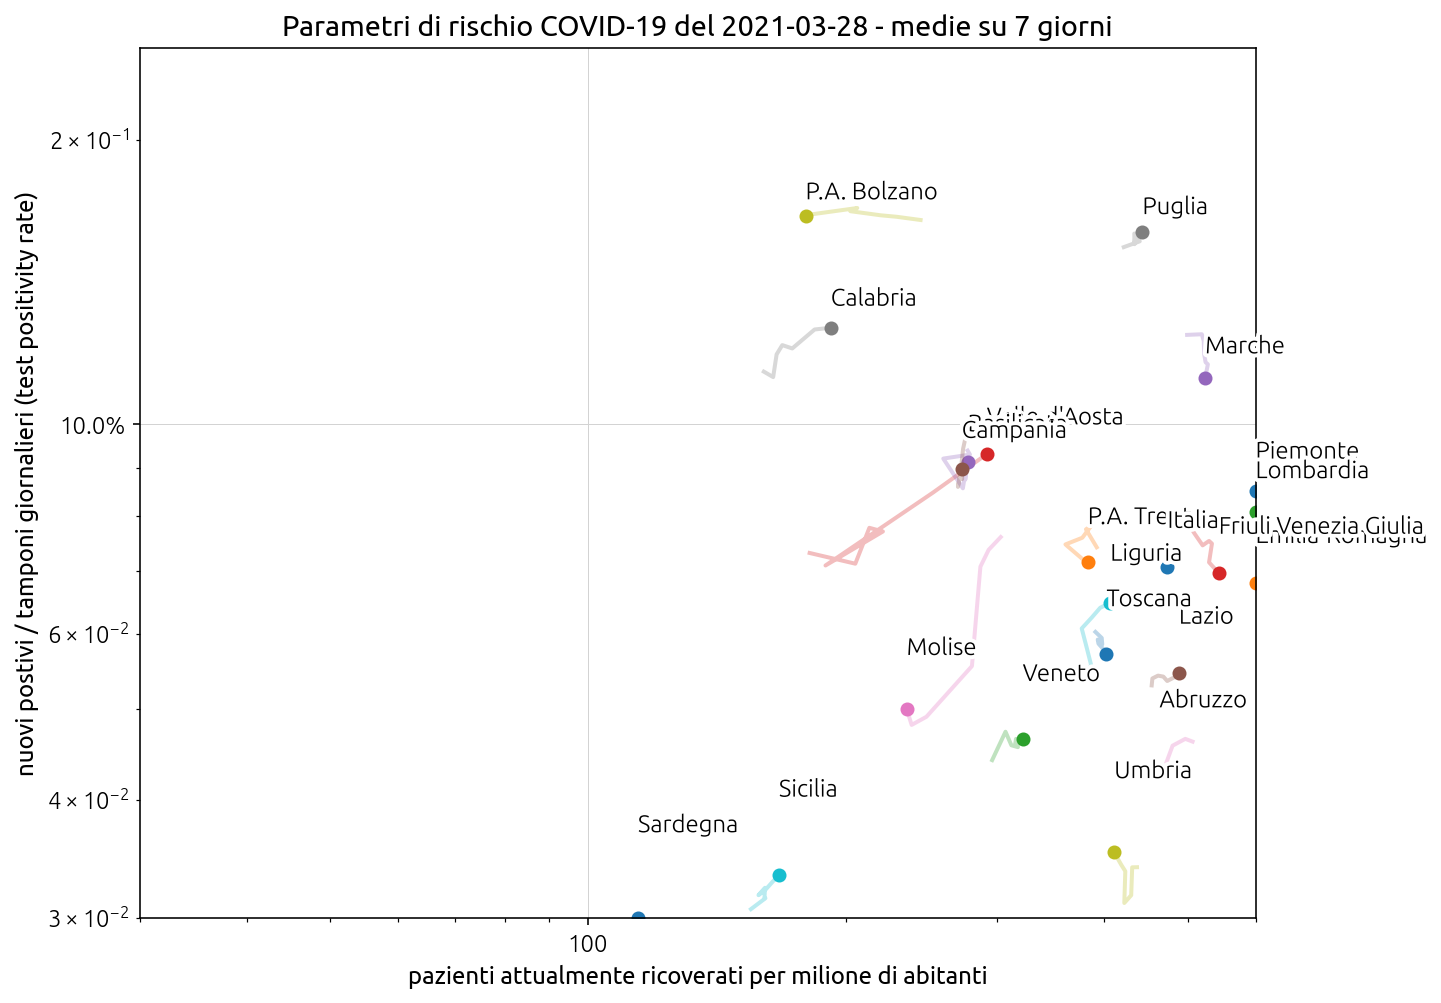

In [414]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['current_severe_pm']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.03, .25)
xlim = (30, 600)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='pazienti attualmente ricoverati per milione di abitanti',
    ylabel='nuovi postivi / tamponi giornalieri (test positivity rate)',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

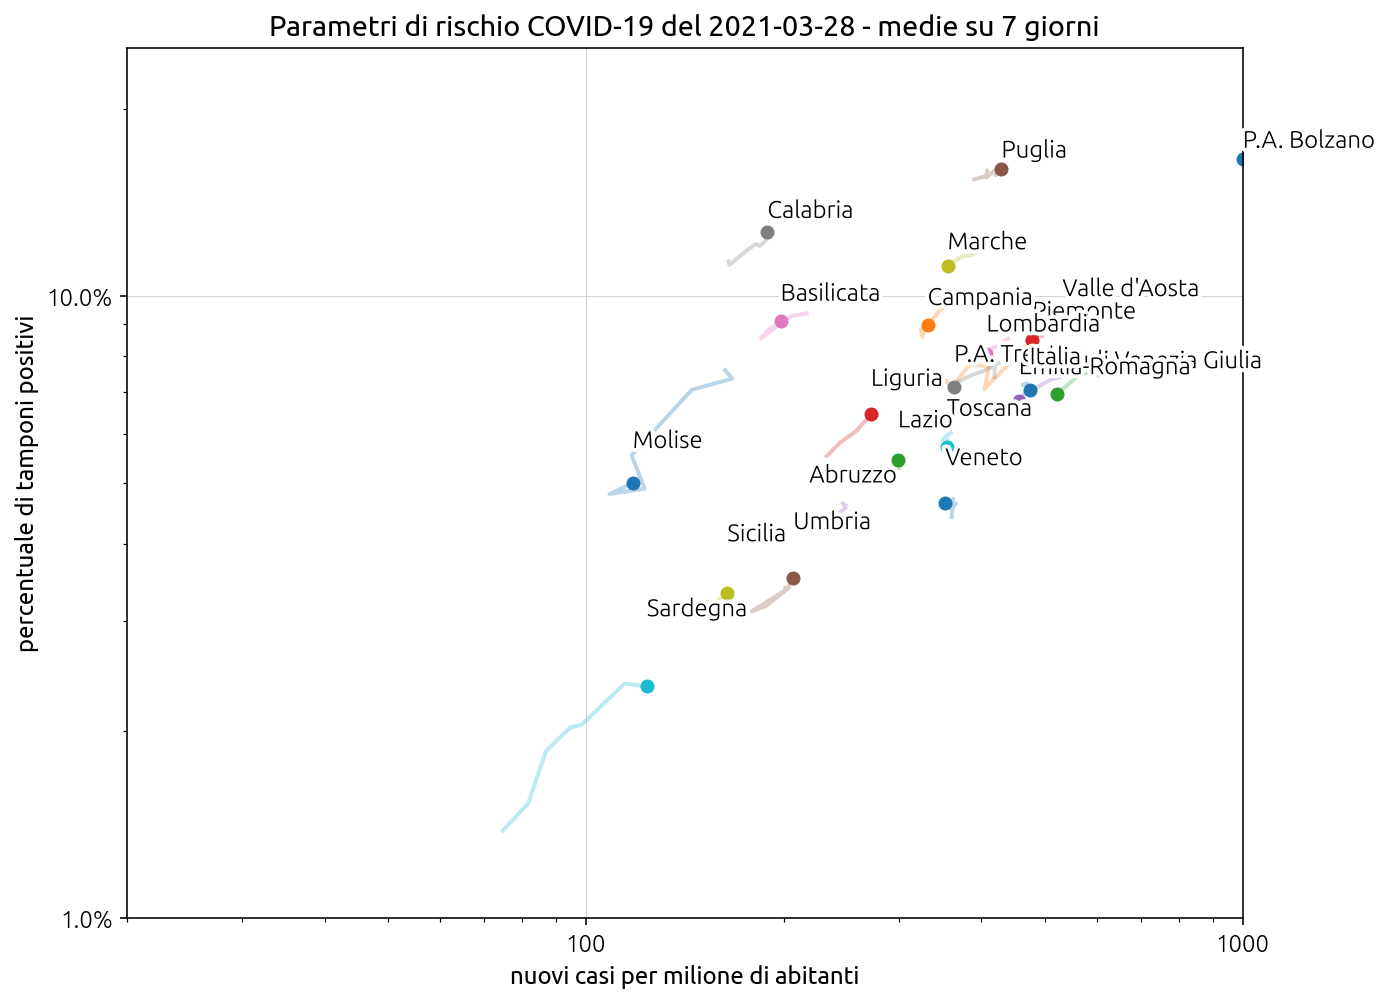

In [415]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['daily_prevalence7']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.01, .25)
xlim = (20, 1000)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='nuovi casi per milione di abitanti',
    ylabel='percentuale di tamponi positivi',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

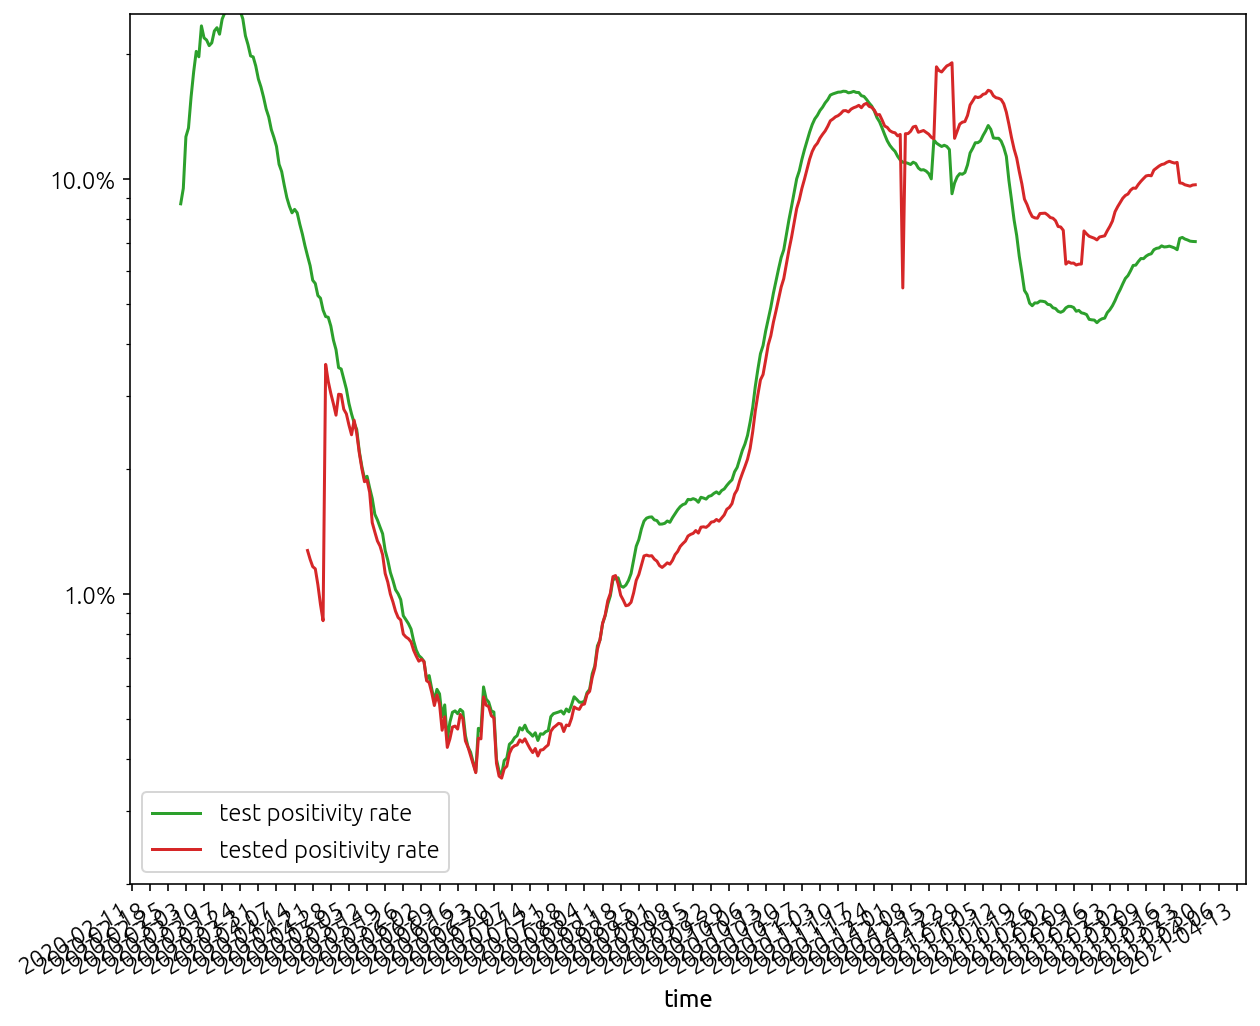

In [416]:
_, ax = plt.subplots()
ax.set(yscale='log', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
covid19.plot.plot_data(ax, ds_italy['daily_tpr7'], label='test positivity rate',  marker=None)
data = ds_italy['daily_confirmed7'] / ds_italy['daily_tested7']
covid19.plot.plot_data(ax, data, label='tested positivity rate', marker=None, ratio=1.9)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0.002, 0.25))
_ = ax.legend()

In [417]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

LAST_DAY = ds_italy.time[-1].values
SHOWUNTIL = LAST_DAY + 30 * DAY

EXTRAPOLATE = (np.datetime64('2020-03-01'), SHOWUNTIL)
XLIM = EXTRAPOLATE

XXX = ['daily_tests_pm7', 'daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7'] 
FIT_PARAMS = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-19', '2020-10-06'],
    'current_severe_pm': ['2020-08-13', '2020-10-06'],
    'current_critical_pm': ['2020-08-07', '2020-10-10'],
    'daily_mortality7': ['2020-08-19', '2020-10-12'],
    'daily_tpr7': [],
    'daily_confirmed7': ['2020-10-06', '2020-10-19', '2020-10-21', '2020-10-23', '2020-11-01', '2020-11-23', None],
    'daily_deaths7': ['2020-10-15', '2020-10-29', '2020-11-12', '2020-11-18'],
}
#FIT_PARAMS = {
#    'daily_tests_pm7': [],
#    'daily_prevalence7': [],
#    'current_severe_pm': [],
#    'current_critical_pm': ['2020-04-15', '2020-07-10'],
#    'daily_mortality7': ['2020-04-19', '2020-08-01'],
#    'daily_tpr7': [],
#    'daily_confirmed7': ['2020-10-06', None],
#}
RATIO = {
    'current_critical_pm': 0.165,
    'daily_mortality7': 0.013,
}
DEALY = {
    'current_critical_pm': -5,
    'daily_mortality7': -7.5,
}
LABEL = {
    'current_severe': 'pazienti attualmente ricoverati in reparto',
    'current_confirmed': 'attualmente positivi',
    'current_severe_pm': 'pazienti attualmente ricoverati in reparto',
    'current_critical': 'pazienti attualmente in terapia intensiva',
    'current_critical_pm': 'pazienti attualmente in terapia intensiva',
    'daily_tests7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_deaths': 'decessi giornalieri',
    'daily_deaths7': 'decessi giornalieri (media su 7 giorni)',
    'daily_confirmed7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_deaths14': 'decessi giornalieri (media su 14 giorni)',
    'daily_confirmed14': 'nuovi casi giornalieri (media su 14 giorni)',
    'daily_prevalence7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_tpr7': 'percentuale di test positivi (media su 7 giorni)',
    'daily_prevalence_screening7': 'nuovi casi da screening (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_mortality7': 'decessi giornalieri (media su 7 giorni)',
    'daily_mortality14': 'decessi giornalieri (media su 14 giorni)',
}

In [418]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['current_severe']]
    fits[kind] = covid19.fit.fit_exponential_segments(ds_italy[kind], breaks=breaks, min_value=0, valid_ratio=0.1)

# fits['daily_deaths7'] = [fit.shift(7).scale(0.013) for fit in fits['daily_confirmed7']]
# fits['daily_confirmed7'].append(fits['daily_confirmed7'][-1].scale(.75))

# fits

skipping start=2020-11-23T00:00:00 stop=None


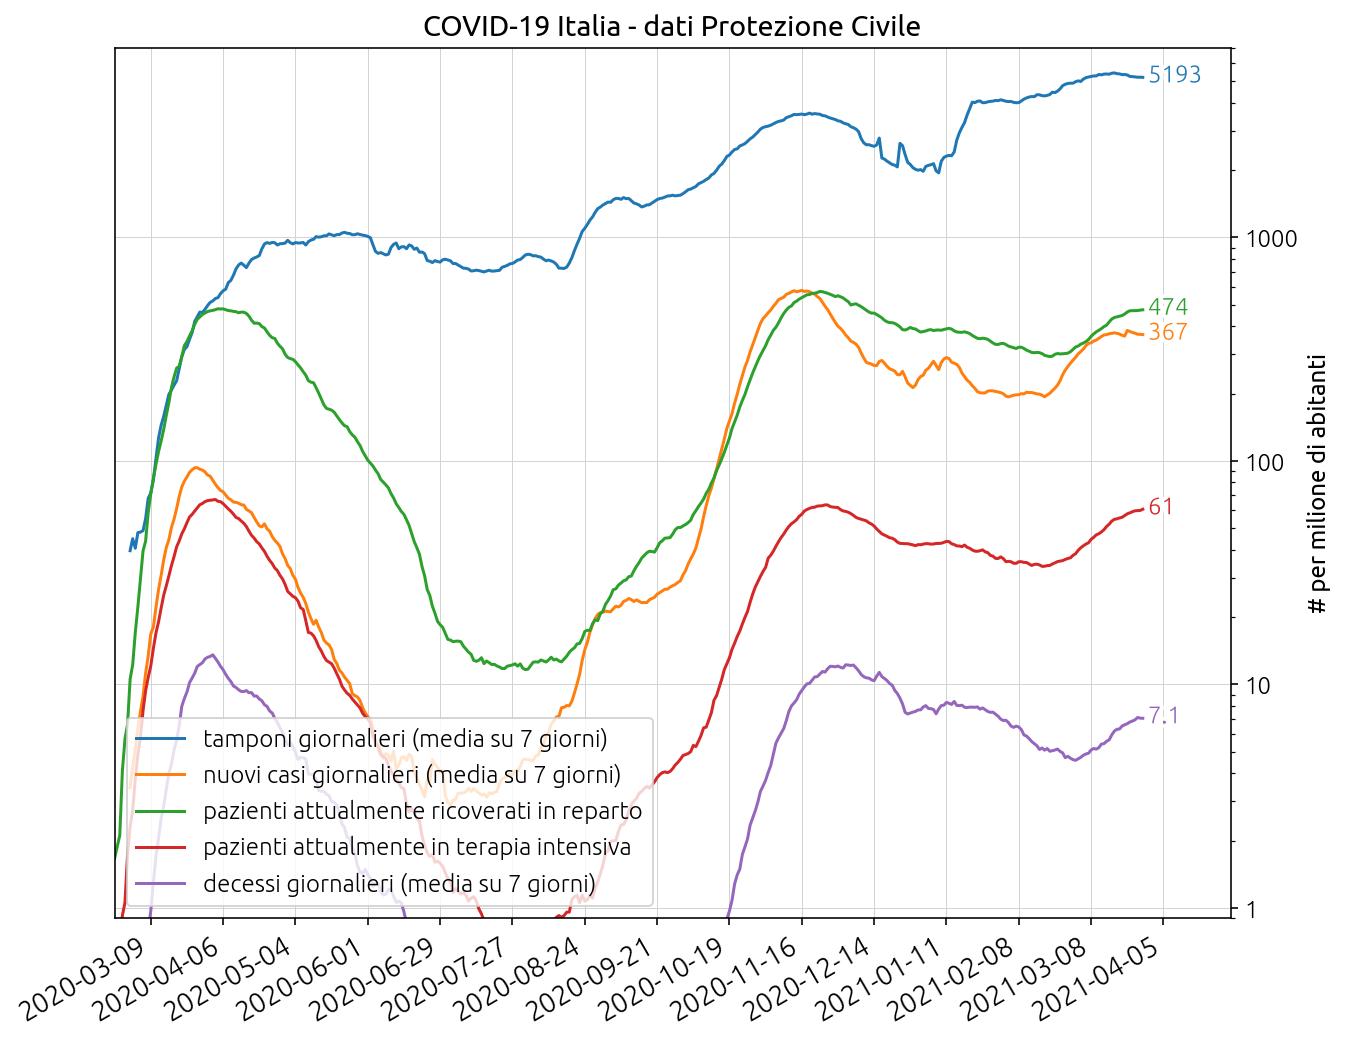

In [419]:
SHOW = ['daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7', 'daily_tests_pm7']

EXTRAPOLATE = (np.datetime64('2020-02-24'), np.datetime64('2021-05-01'))
XLIM = EXTRAPOLATE

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.9, 7000)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    if SHOW is not None and kind not in SHOW:
        continue
    label = LABEL.get(kind, '')
    ratio = RATIO.get(kind, 1.)
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=28, marker=None, annotate=True)
    #for i, fit in enumerate(fits_kind):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7], alpha=0.5)

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)
    
_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
_ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = ax.legend(loc='lower left')

[ 15300  20400  23000  24900  25700  23900  20000 -74300  22500  25200
  27200  28000  26300  22500 -71700  25200  28000  30000  31000  29400
  25700]
[ 11169.  14892.  16790.  18177.  18761.  17447.  14600. -54239.  16425.
  18396.  19856.  20440.  19199.  16425. -52341.  18396.  20440.  21900.
  22630.  21462.  18761.]


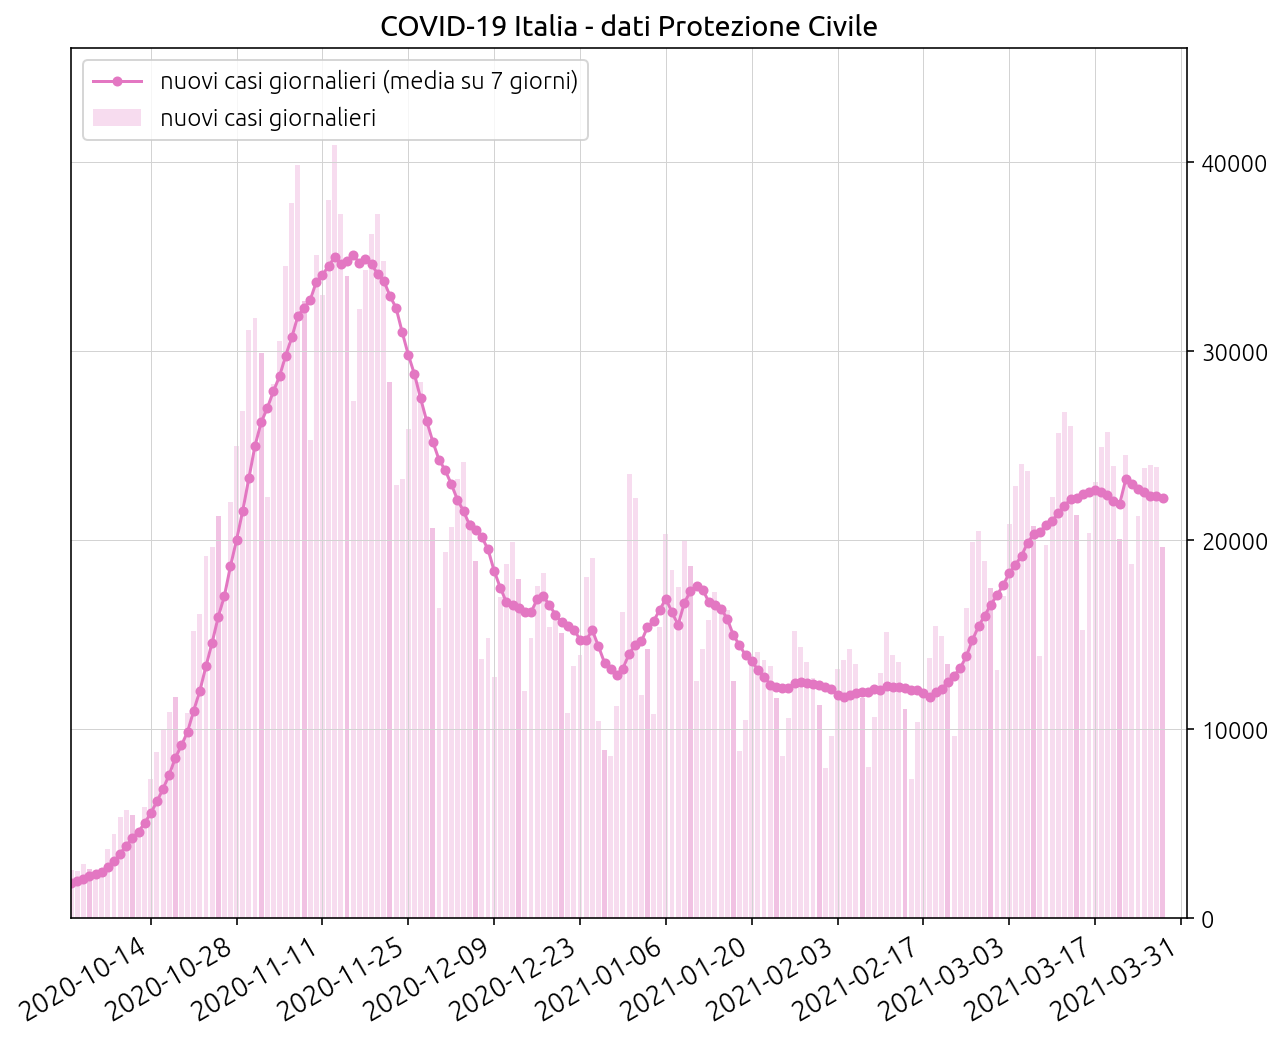

In [421]:
HIGHLIGHT_DAY = 6

XLIM1 = (np.datetime64('2020-10-01'), np.datetime64('2021-04-01'))

SHOW = ['daily_confirmed7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 46000)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14, markersize=4)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], ds_italy[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-1:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-07') + i * DAY for i in range(-6, 8)], 0.73 * np.array([37000, 32500, 38700, 43100, 46400, 52200, 54600, 61800, 59200, 67700, 74400, 80200, 88800, 94200]), ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-10-28')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = list(ds_italy['daily_confirmed'][-14:-7].values)
for i in range(-6, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(round(mean))
    values.append(round(mean * 7 - sum(values[-6:])))
print(np.array([int(round(v / 100)) * 100 for v in values]))
print(0.73 * np.array([int(round(v / 100)) * 100 for v in values]))

[ 2200  4200  4500  5600  5500  4800  4000 35000  6400  6700  7900  7900
  7200  6500 37600  9000  9400 10800 10800 10300  9600]
[1980.0, 3780.0, 4050.0, 5040.0, 4950.0, 4320.0, 3600.0, 31500.0, 5760.0, 6030.0, 7110.0, 7110.0, 6480.0, 5850.0, 33840.0, 8100.0, 8460.0, 9720.0, 9720.0, 9270.0, 8640.0]


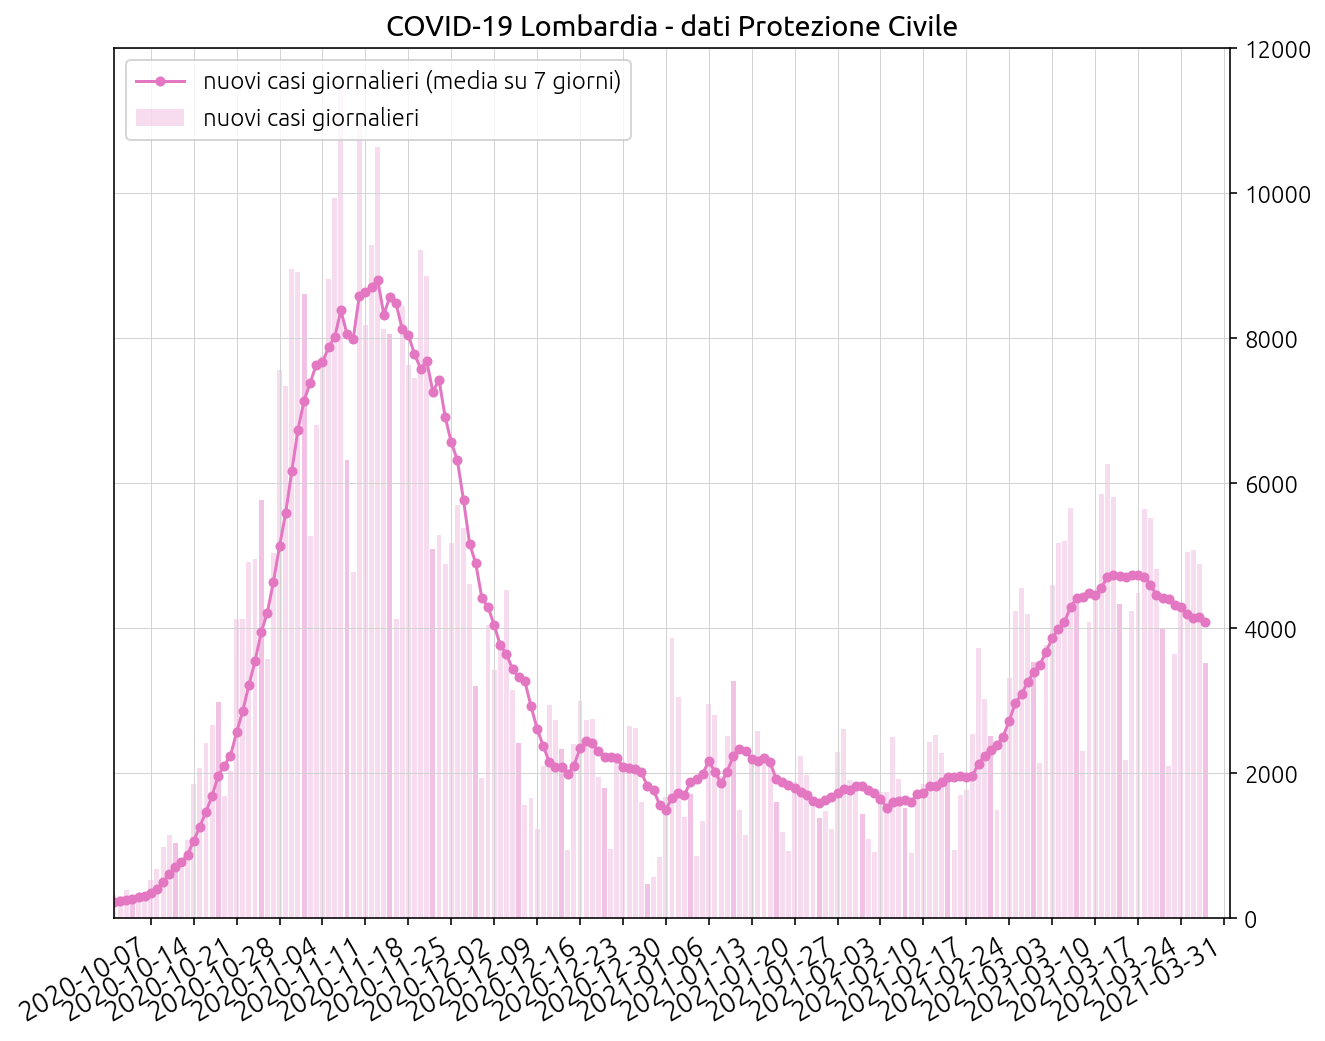

In [422]:
SHOW = ['daily_confirmed7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 12000)})

data = ds_italy_regions.sel(location='Lombardia')

count = 0
for (kind, fits_kind), color in zip(region_fits['Lombardia'].items(), PALETTE_ONE):
    color = 'tab:pink'
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(ds_italy.time, data[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-07') + i * DAY for i in range(-6, 8)], 0.73 * np.array([9270.0, 7650.0, 9450.0, 12150.0, 12510.0, 14580.0, 15120.0, 17100.0, 16200.0, 18810.0, 22410.0, 23760.0, 26820.0, 28620.0]), ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-10-28')

_ = ax.set_title(f'COVID-19 Lombardia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = list(data['daily_confirmed'][-14:-7].values)
for i in range(-6, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(round(mean))
    values.append(round(mean * 7 - sum(values[-6:])))
print(np.array([int(round(v / 100)) * 100 for v in values]))
print((0.9 * np.array([int(round(v / 100)) * 100 for v in values])).tolist())

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
[11449, 11830, 12224, 12632, 13053, 13487, 13937]
[386, 551, 460, 460, 457, 380, 297, 77538, 3221, 3218, 3311, 3403, 3423, 3442]


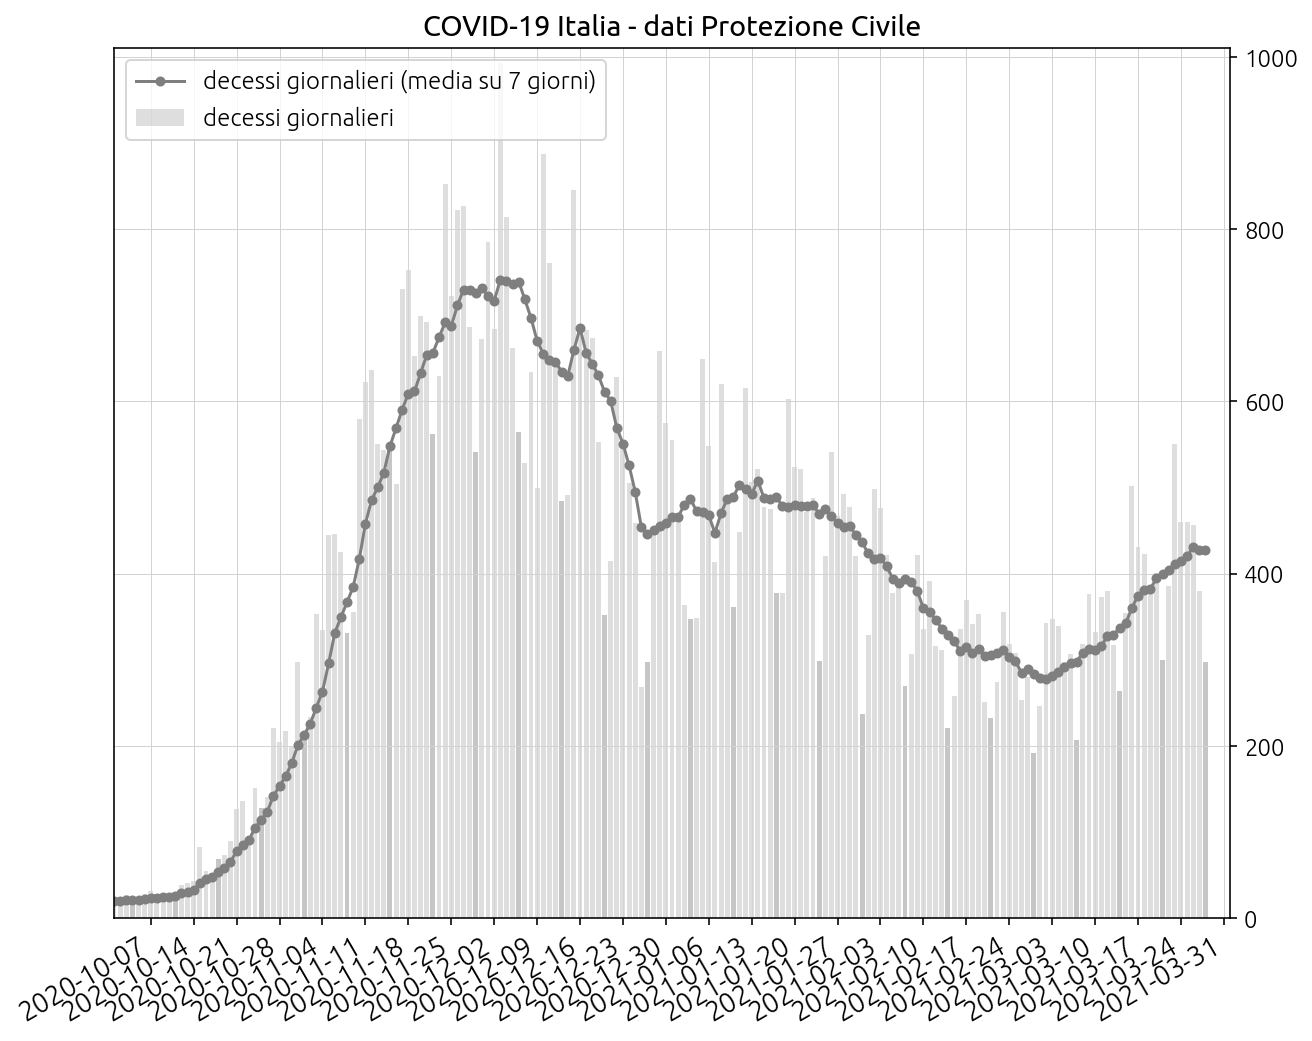

In [423]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 1010)})

data = ds_italy
fits_data = fits

count = 0
for (kind, fits_kind), color in zip(fits_data.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    print(color)
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='decessi giornalieri')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-2:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-23') + i * DAY for i in range(1, 8)], [835, 858, 760, 809, 804, 676, 747], ' x', color=color, label='stima dei decessi nello scenario del 2020-11-16')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = [int(v) for v in ds_italy['daily_deaths'].isel(time=slice(-7, None)).values]
for i in range(1, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(int(round(mean)))
    value = int(round(mean * 7 - sum(values[-6:])))
    values.append(value)
print(means)
print(values)

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


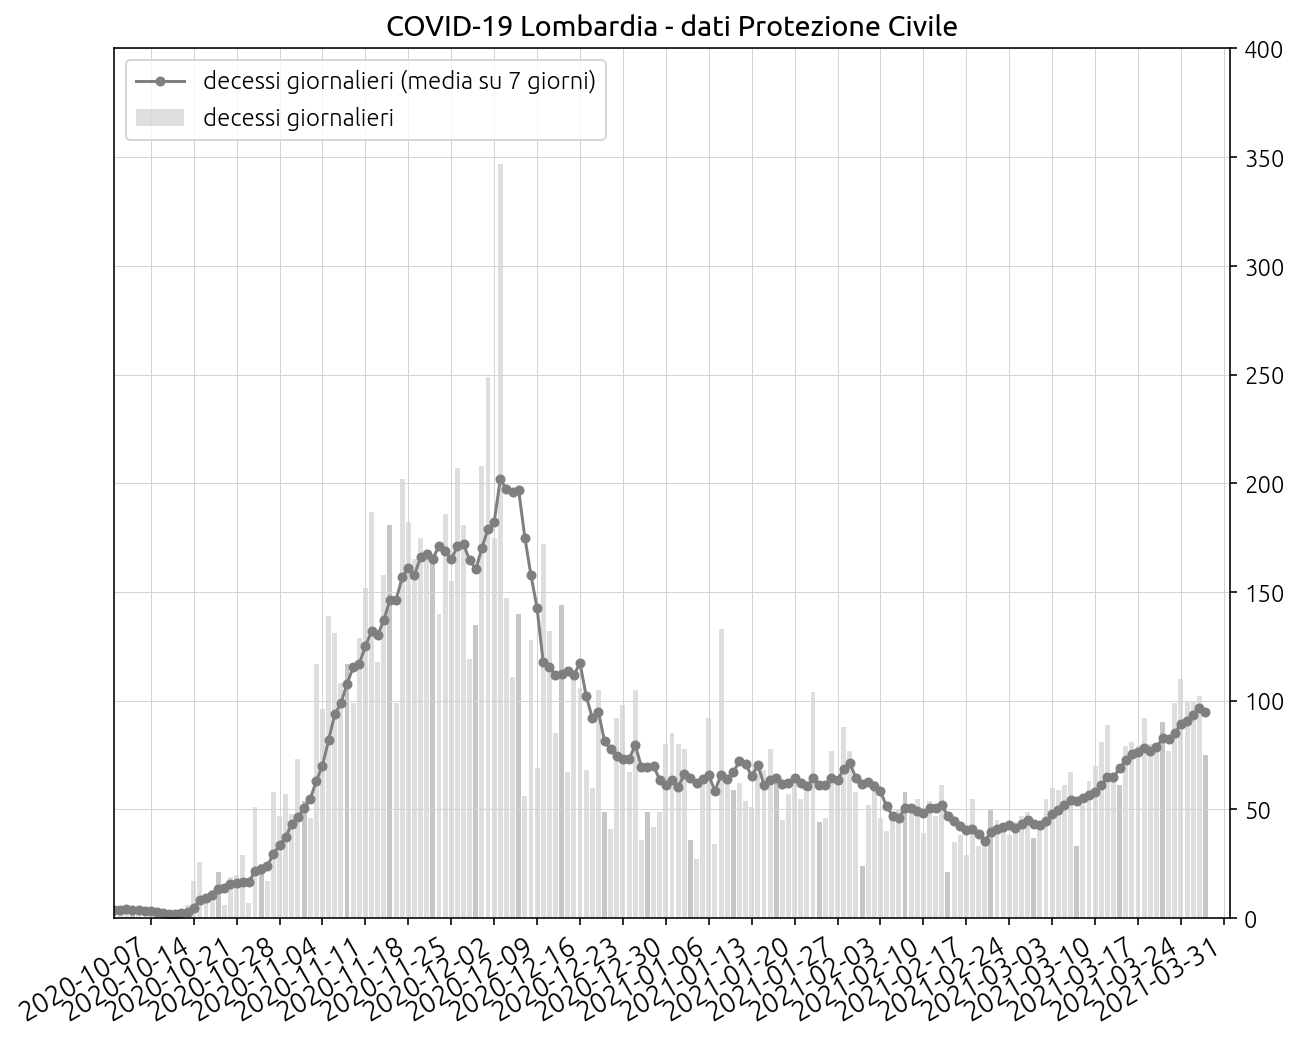

In [424]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 400)})

data = ds_italy_regions.sel(location='Lombardia') # + ds_italy_regions.sel(location='Piemonte') + ds_italy_regions.sel(location="Valle d'Aosta")
fits_data = region_fits['Lombardia']

count = 0
for (kind, fits_kind), color in zip(fits_data.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    print(color)
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='decessi giornalieri')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-2:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

#ax.plot([np.datetime64('2020-11-16') + i * DAY for i in range(1, 8)], [182, 191, 229, 160, 203, 227, 147], ' x', color=color, label='stima dei decessi nello scenario del 2020-11-16')

_ = ax.set_title(f'COVID-19 Lombardia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


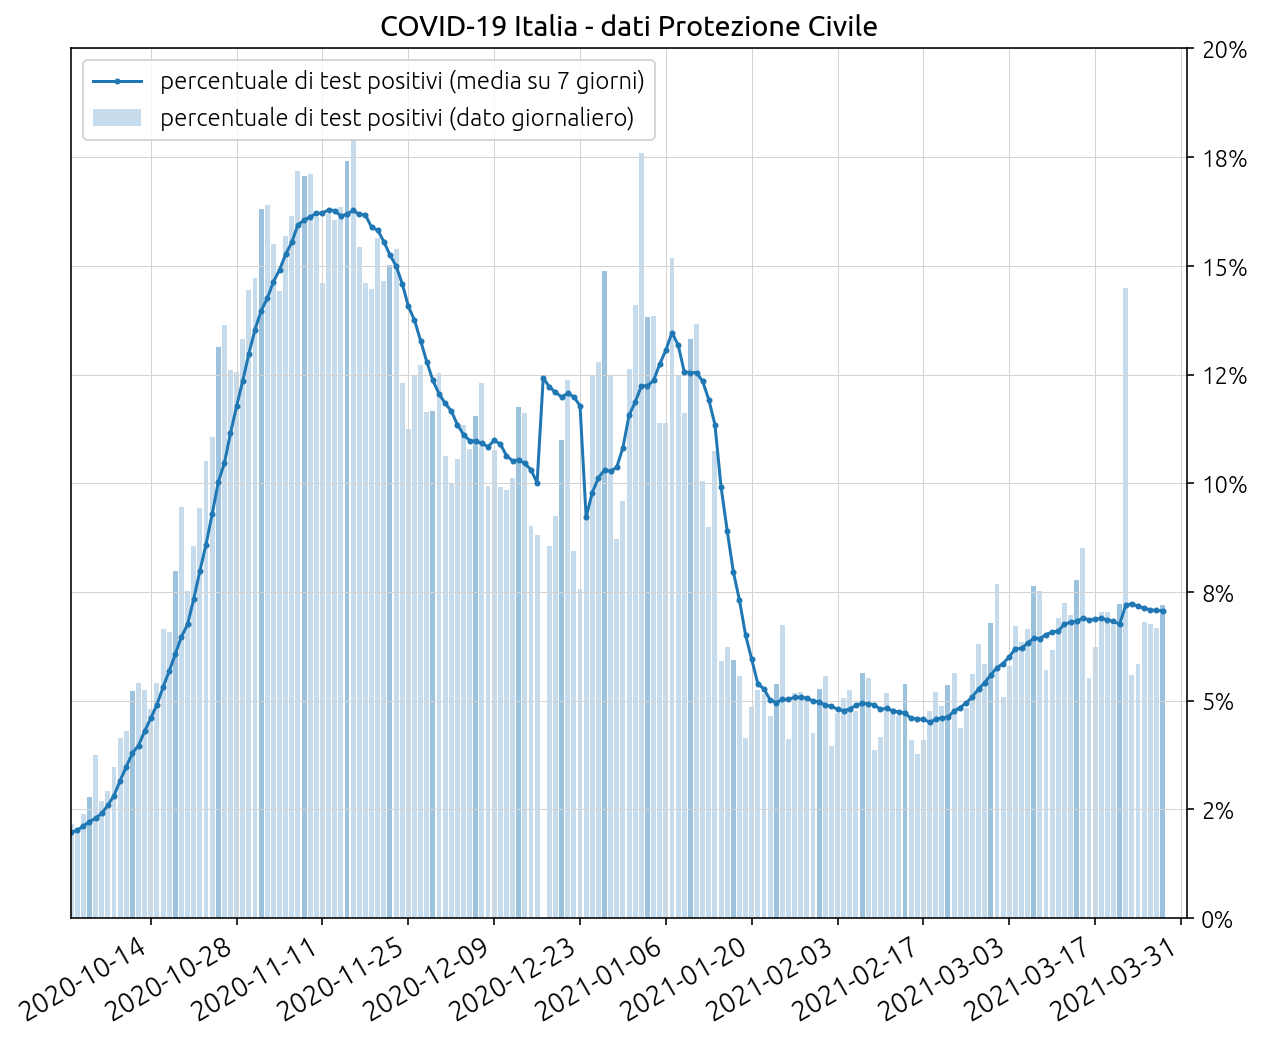

In [425]:
SHOW = ['daily_tpr7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 0.20)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    color = 'tab:blue'
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='percentuale di test positivi (dato giornaliero)')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], ds_italy[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(ylim=(0, None))

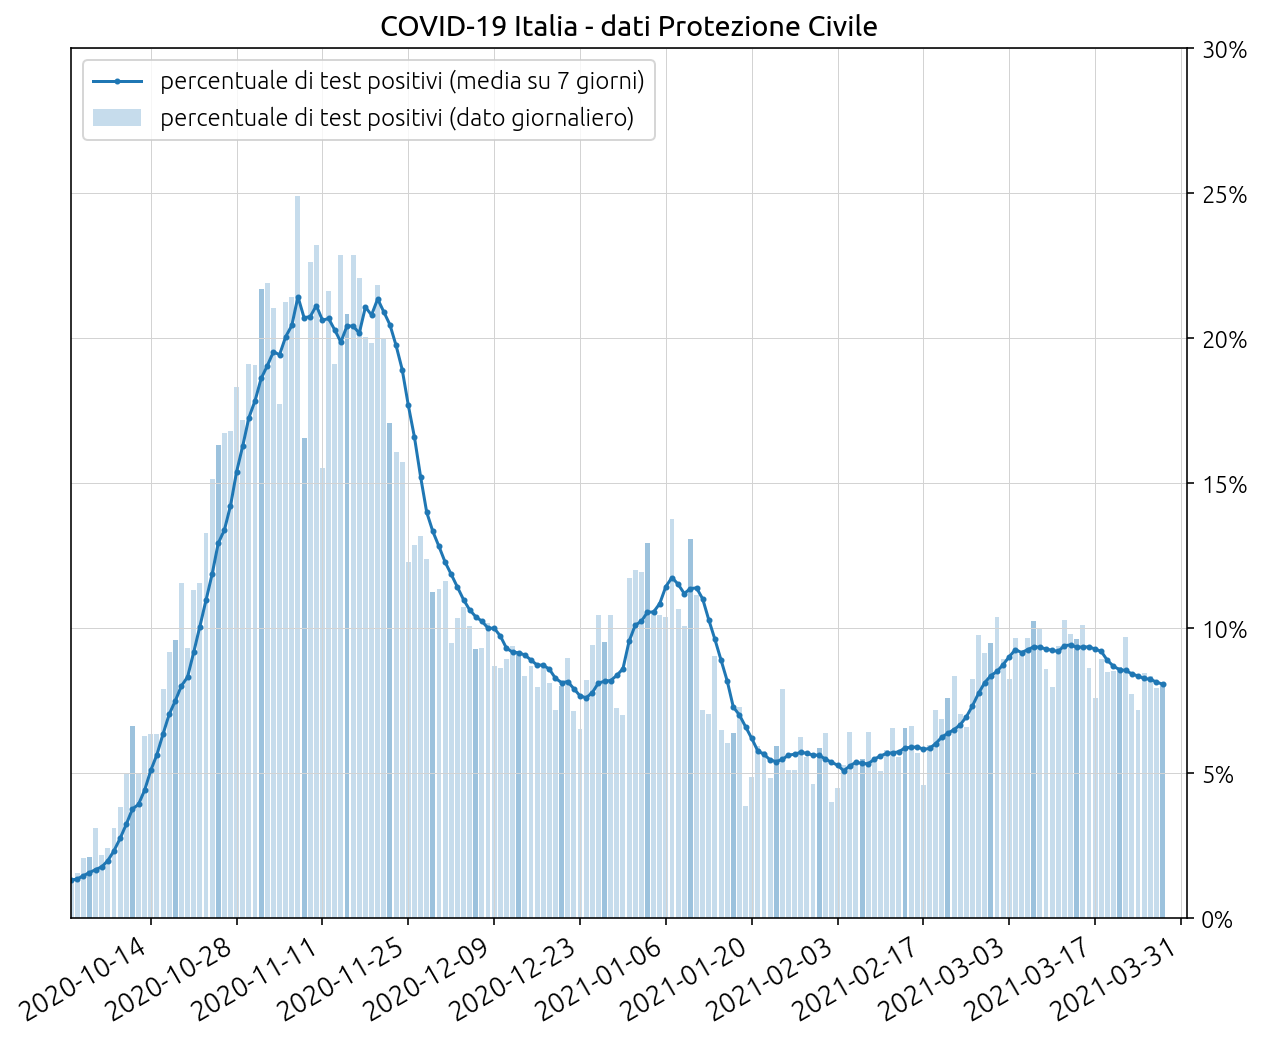

In [426]:
SHOW = ['daily_tpr7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'ylim': (0, 0.30)})

data = ds_italy_regions.sel(location='Lombardia')

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    color = 'tab:blue'
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=14)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='percentuale di test positivi (dato giornaliero)')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(ylim=(0, None))

In [427]:
REGIONS_FIT_PARAMS_DEFAULT = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-10', None],
    'current_severe_pm': ['2020-07-20', None],
    'current_critical_pm': ['2020-07-25', None],
    'daily_mortality7': ['2020-09-01', None],
}
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'daily_tests7': [],
        'daily_prevalence7': ['2020-07-23', '2020-10-06', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-05', '2020-10-10', None],
        'daily_mortality7': ['2020-08-01', '2020-10-15', None],
        'daily_confirmed7': ['2020-10-06', '2020-10-23', '2020-11-01', None],
        'daily_deaths7': ['2020-10-15', '2020-11-09', '2020-11-22'],
        'daily_confirmed14': ['2020-10-06', '2020-10-23', '2020-11-01', None],
        'daily_deaths14': ['2020-10-15', '2020-11-09', '2020-11-22'],
    },
    'Lazio': {
        'daily_prevalence7': ['2020-08-01', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-25', None],
        'daily_mortality7': ['2020-09-05', None],
    },
    'Campania': {
    },
    'Sicilia': {
        'daily_prevalence7': ['2020-07-17', None],
        'daily_mortality7': ['2020-09-15', None],
    },
    'Veneto': {
        'daily_prevalence7': ['2020-07-10', None],
        'current_severe_pm': ['2020-08-10', None],
    },
    'Emilia-Romagna': {
        'daily_prevalence7': ['2020-06-10', None],        
    },
    'Sardegna': {
        'daily_prevalence7': ['2020-07-10', '2020-09-05', None],
        'current_severe_pm': ['2020-08-01', None],
        'current_critical_pm': [],
    },
    'Liguria': {
        'current_severe_pm': [],
    },
    'Puglia': {
        'daily_prevalence7': ['2020-07-20', '2020-09-10'],
        'current_severe_pm': ['2020-07-20', '2020-09-10'],
        'current_critical_pm': ['2020-07-25', '2020-09-20'],
    },
    'Marche':{
        'daily_prevalence7': ['2020-07-30', None],
    },
    'Basilicata': {
        'daily_prevalence7': ['2020-07-20', None],
    },
 }

STOP_FIT = '2020-04-03'

region_fits = {}
for region in REGIONS:
    params = REGIONS_FIT_PARAMS_DEFAULT.copy()
    params.update(REGIONS_FIT_PARAMS.get(region, {}))
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['current_severe']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds_italy_regions.sel(location=region)[kind], breaks=breaks, min_value=0, valid_ratio=0.1)

skipping start=2020-10-06T00:00:00 stop=None
skipping start=2020-10-15T00:00:00 stop=None


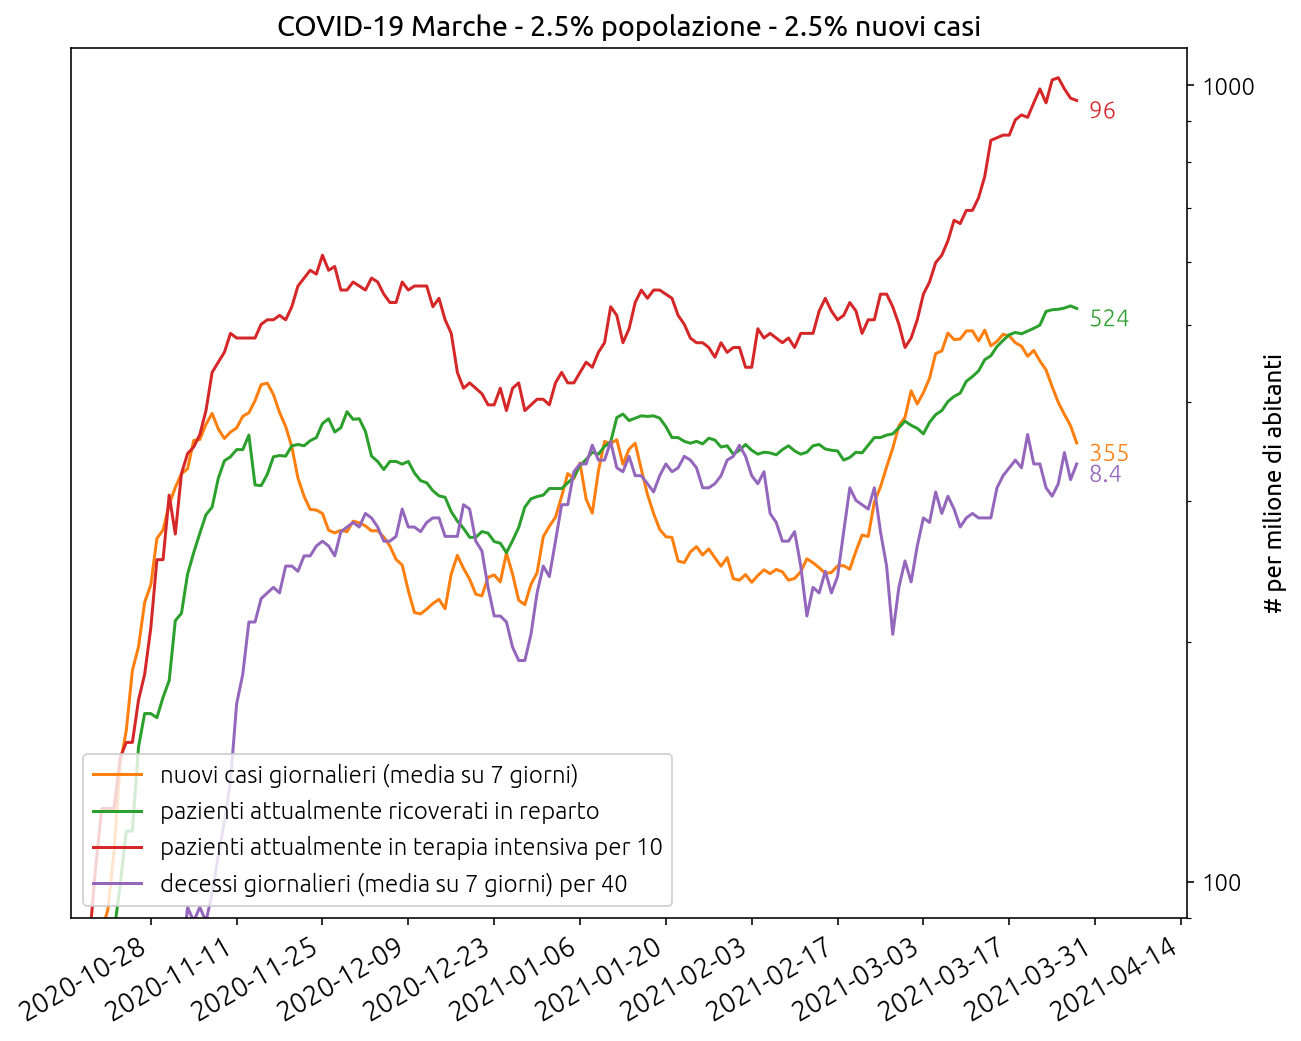

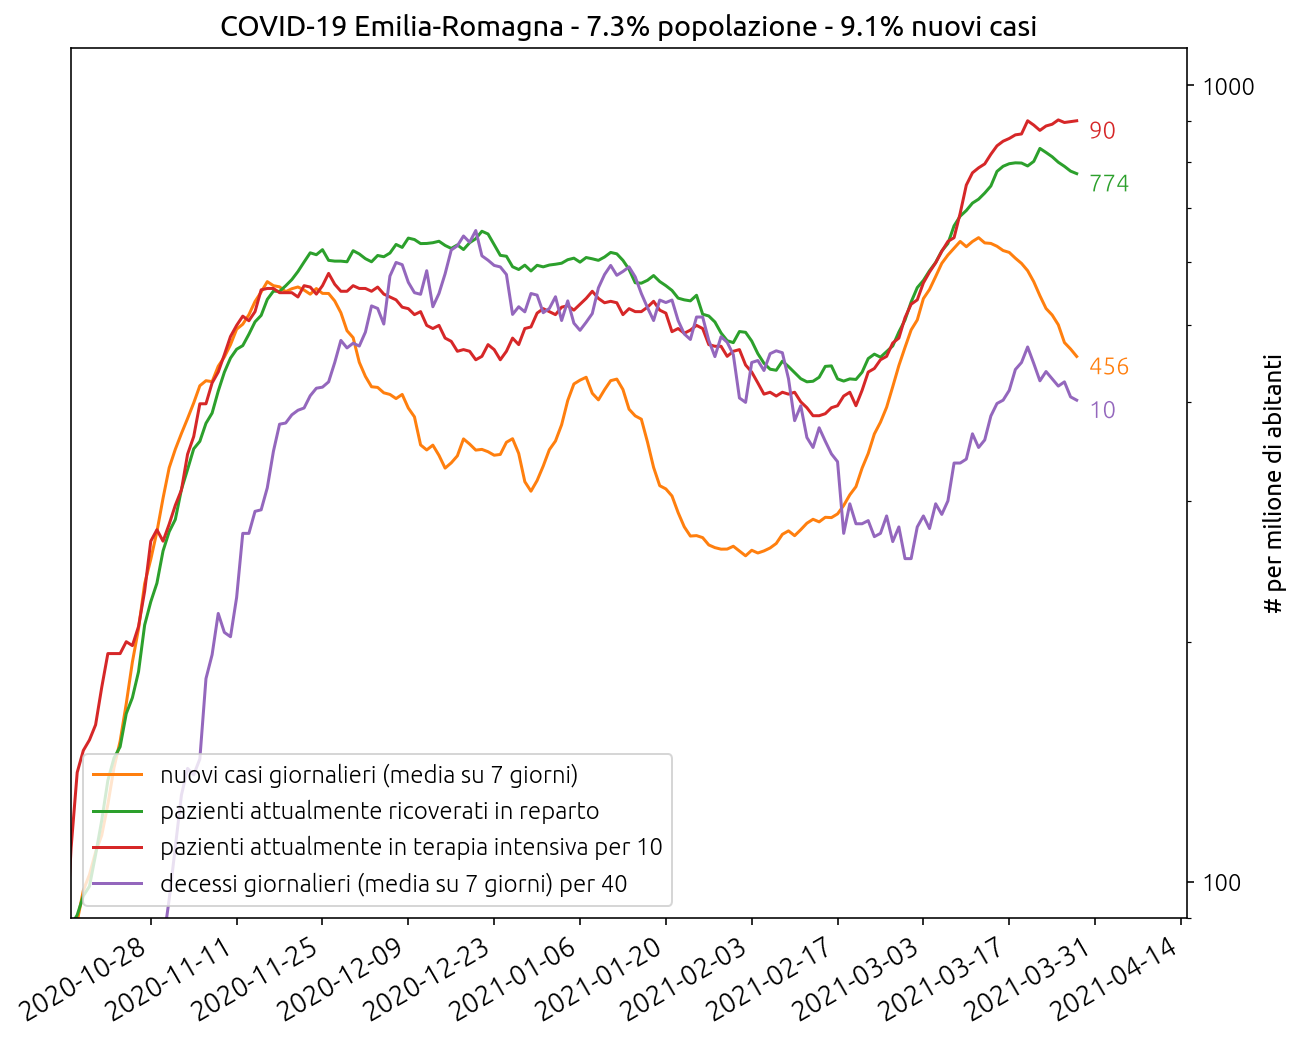

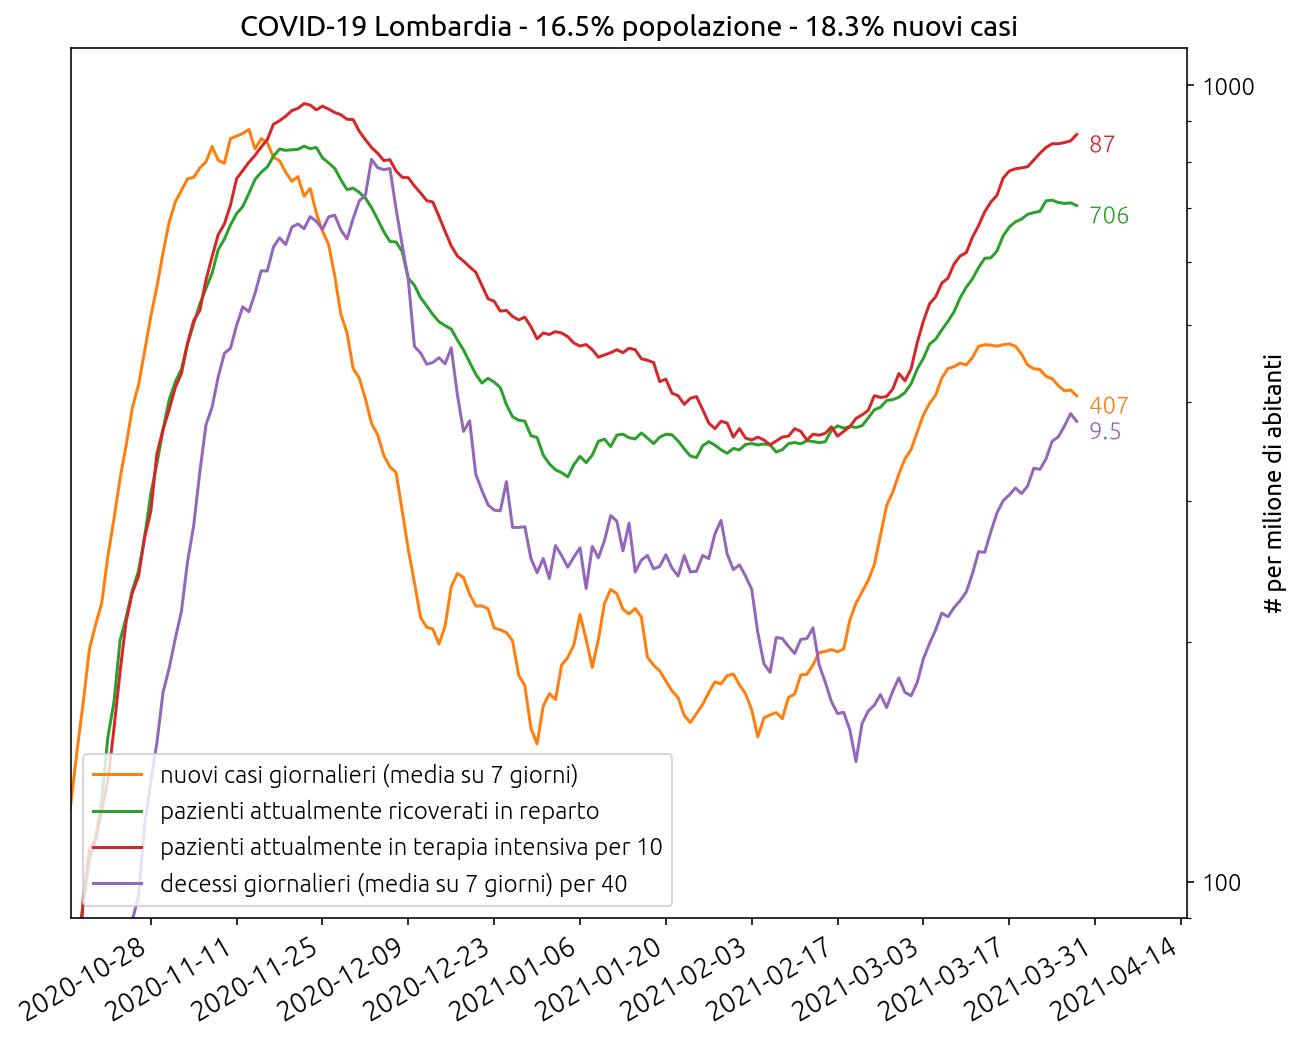

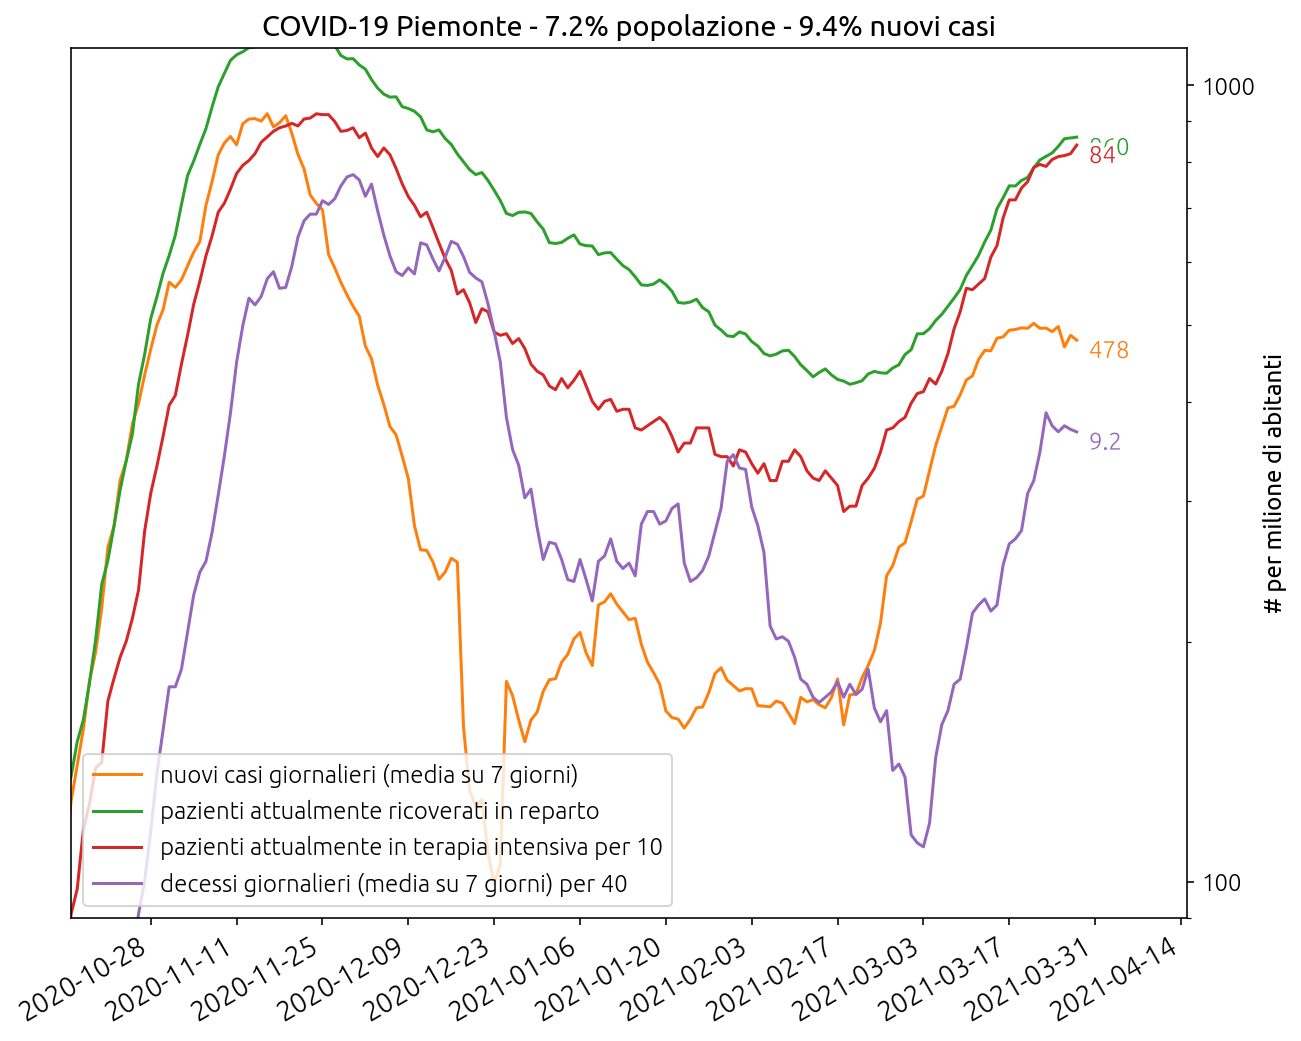

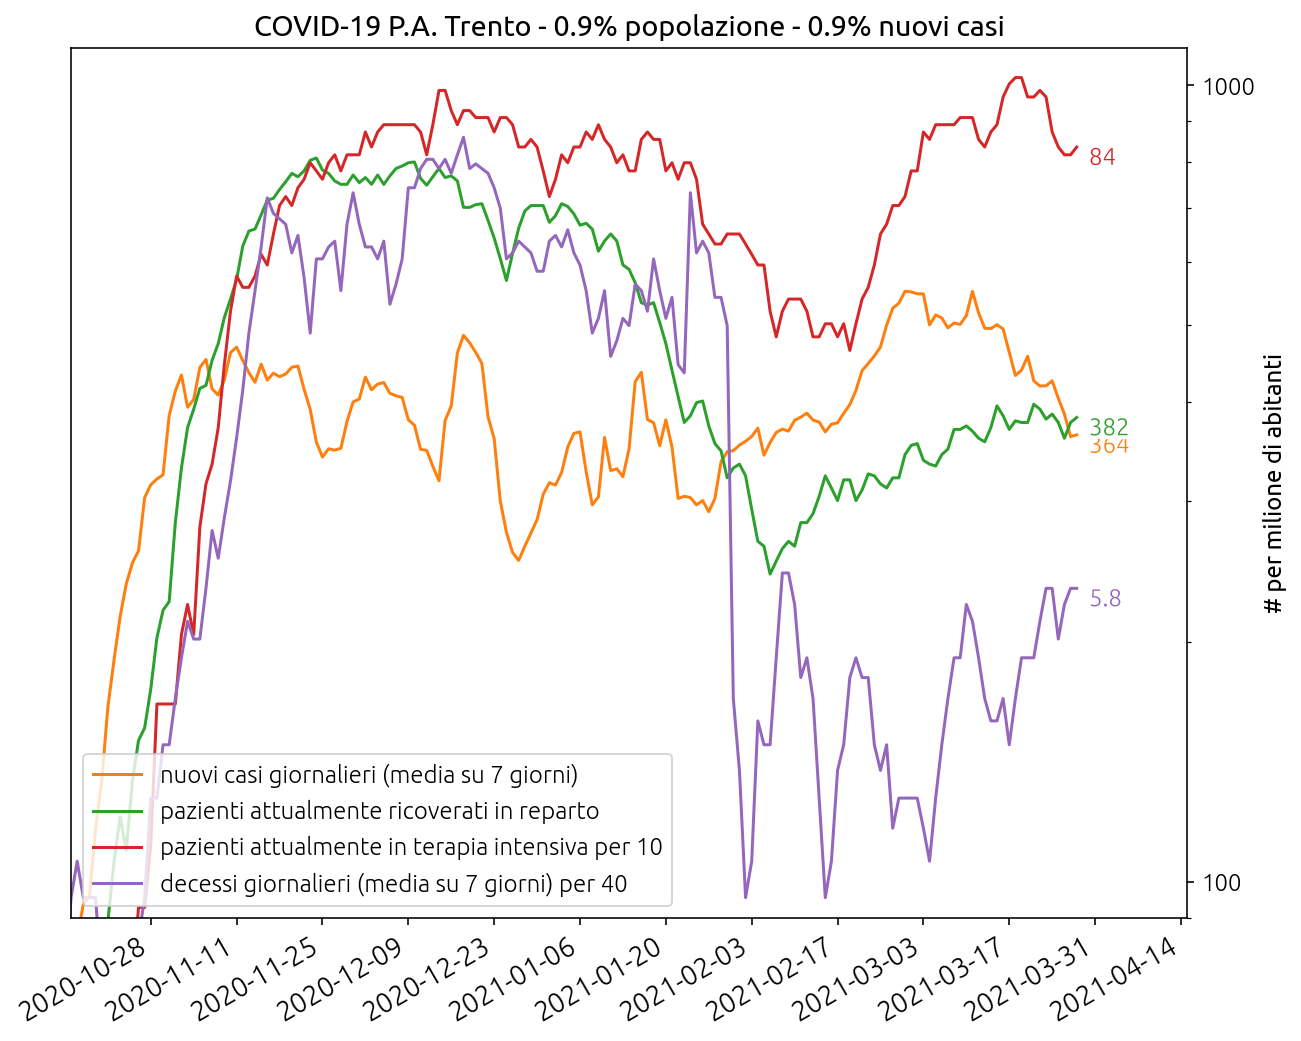

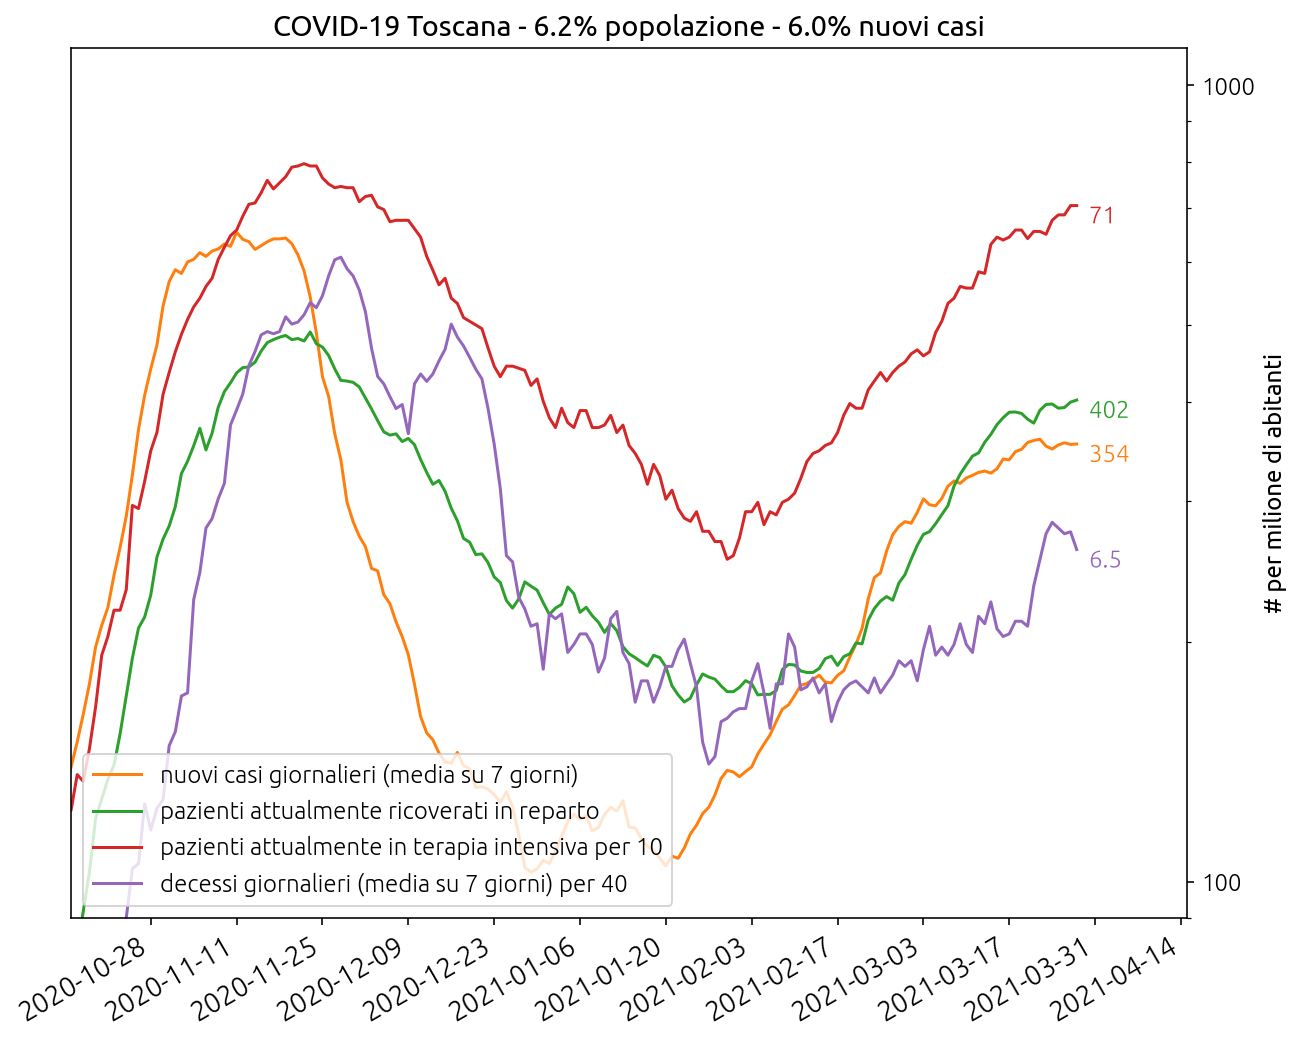

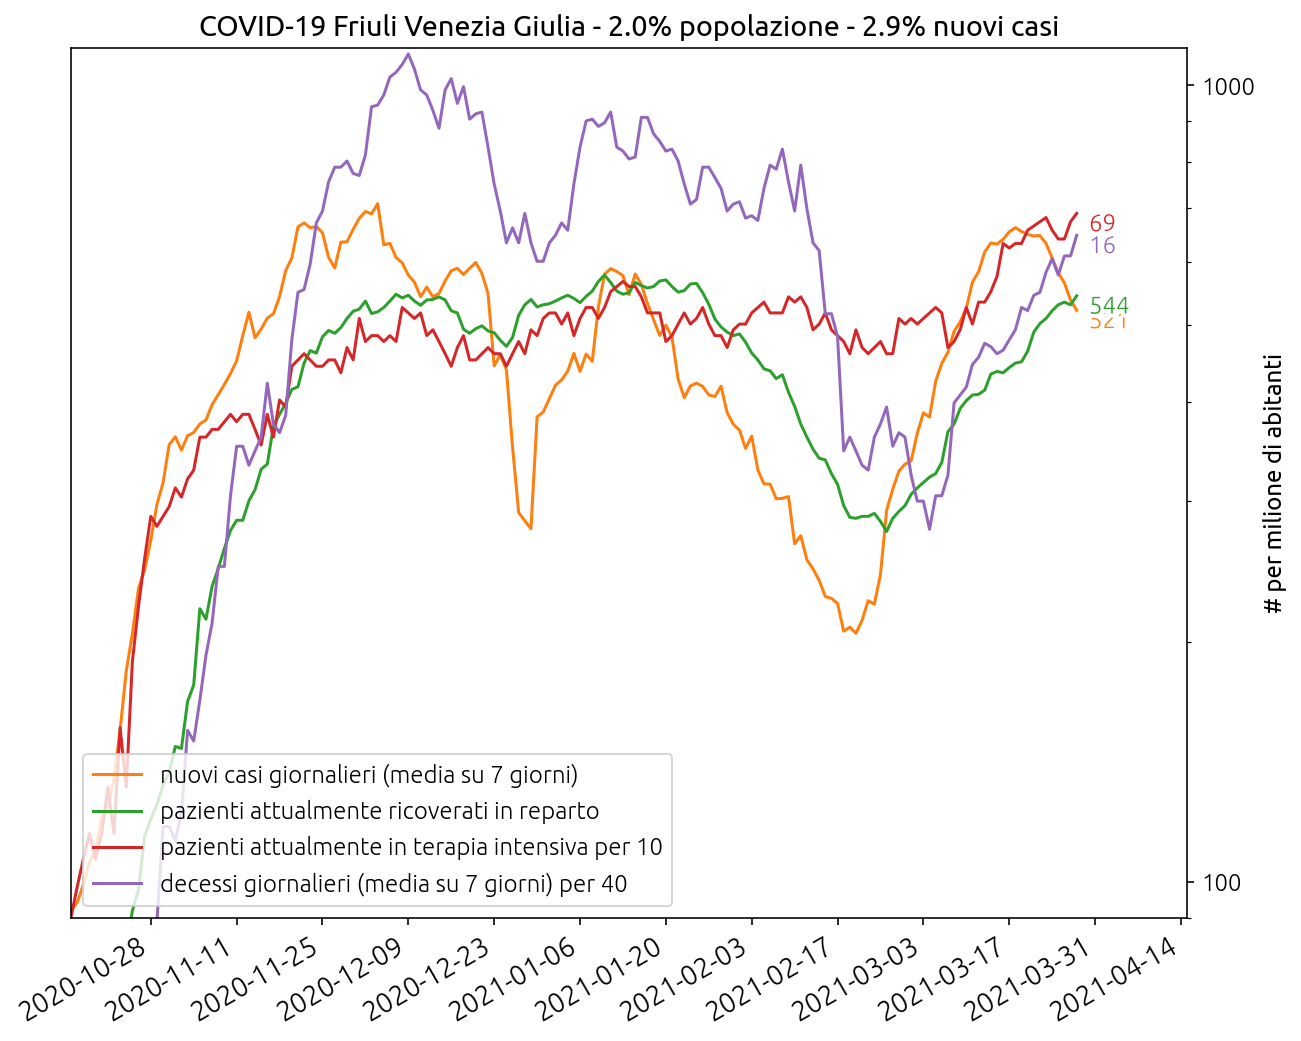

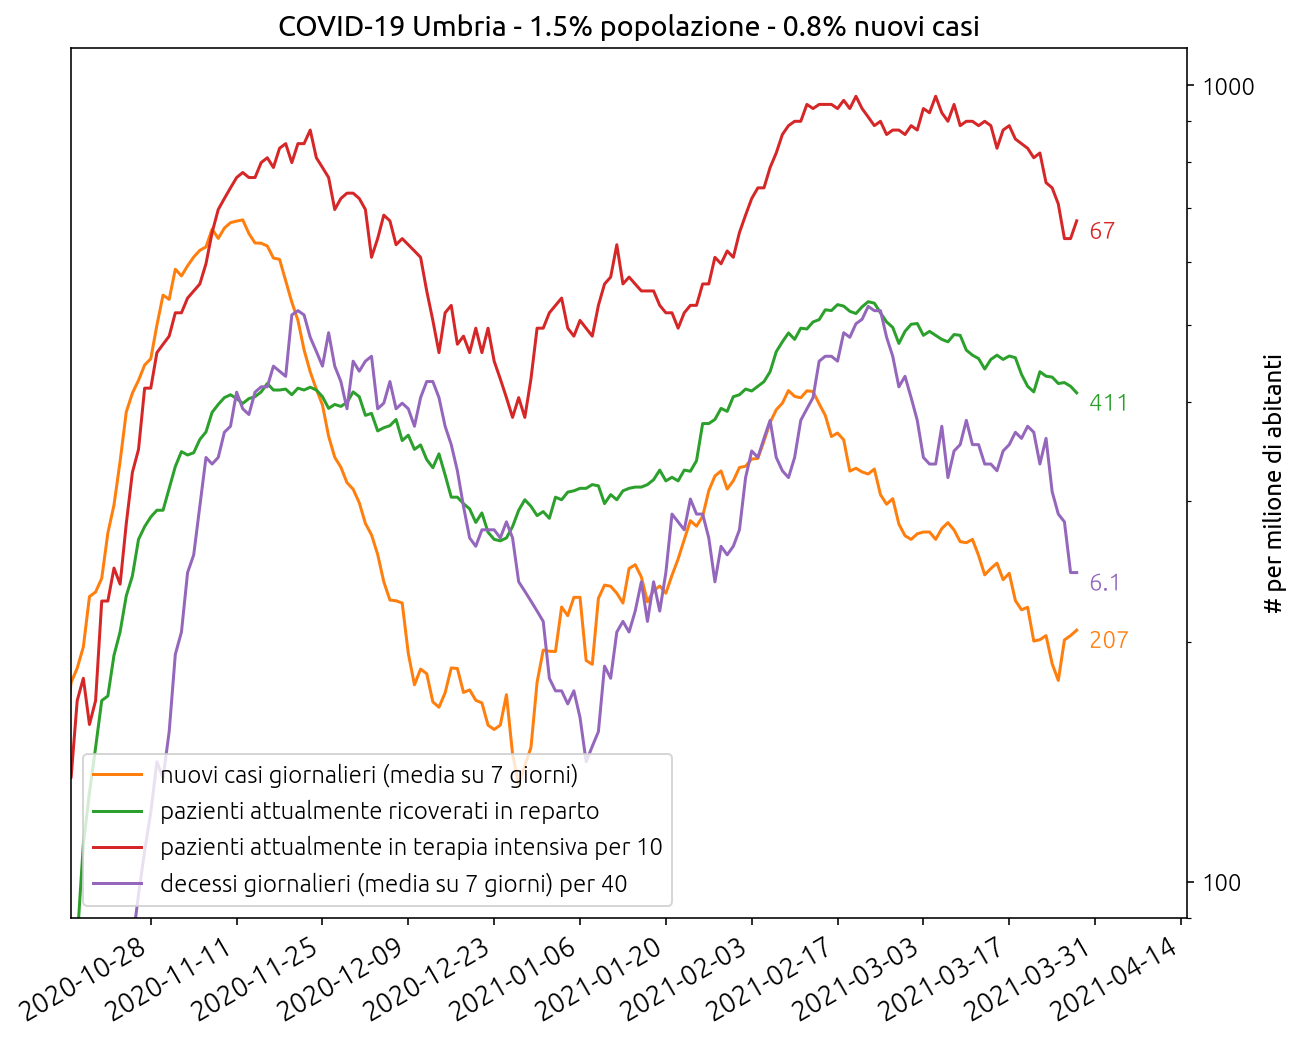

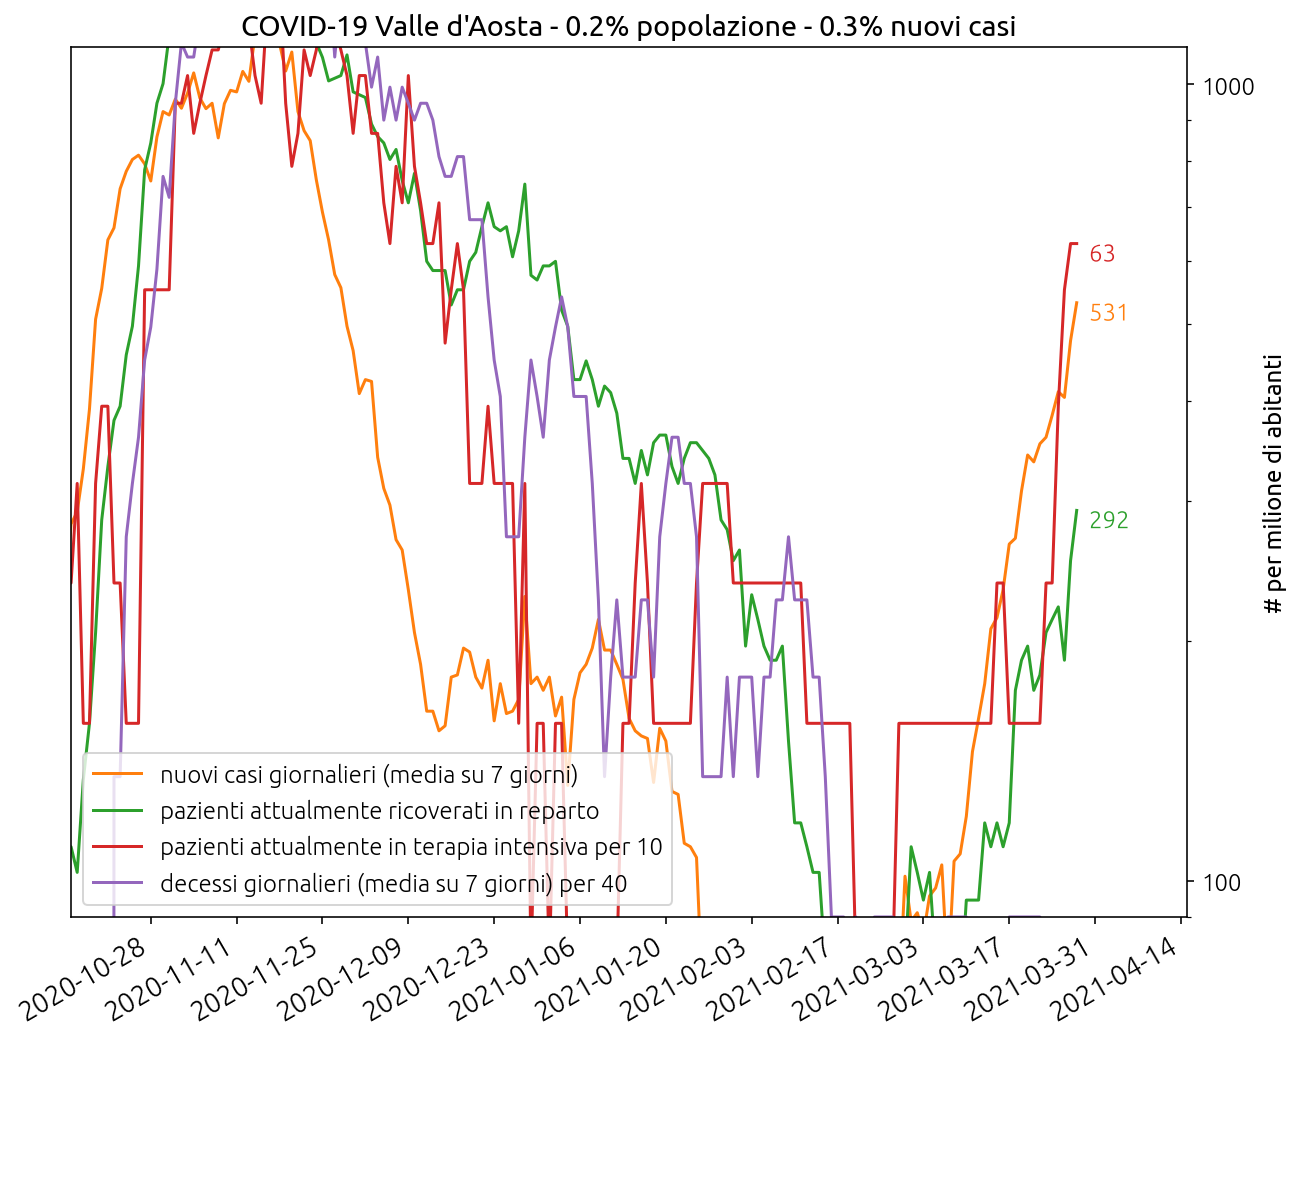

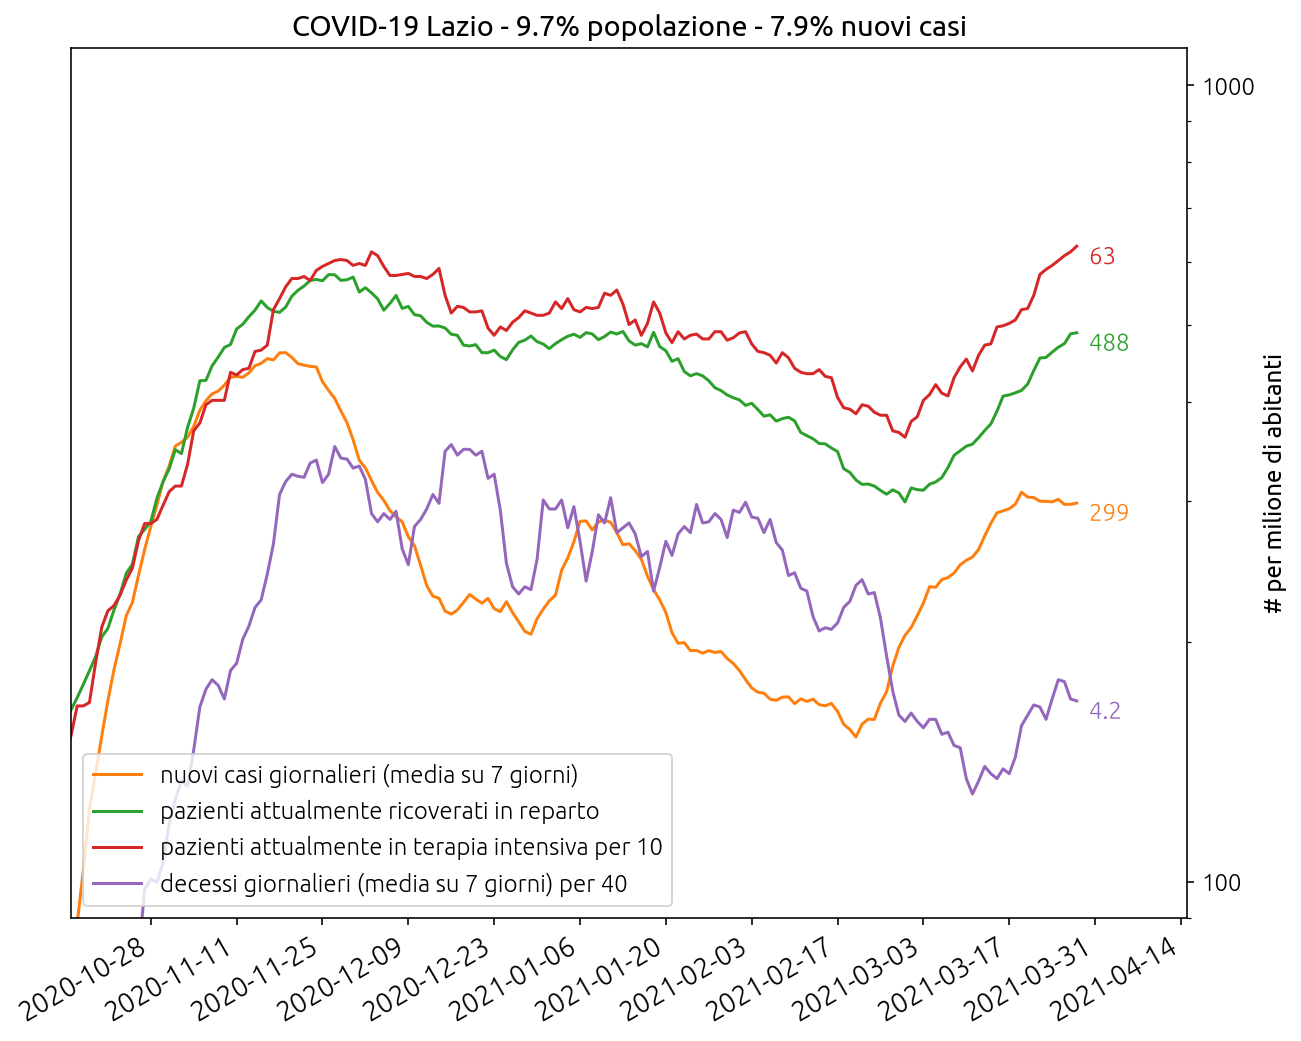

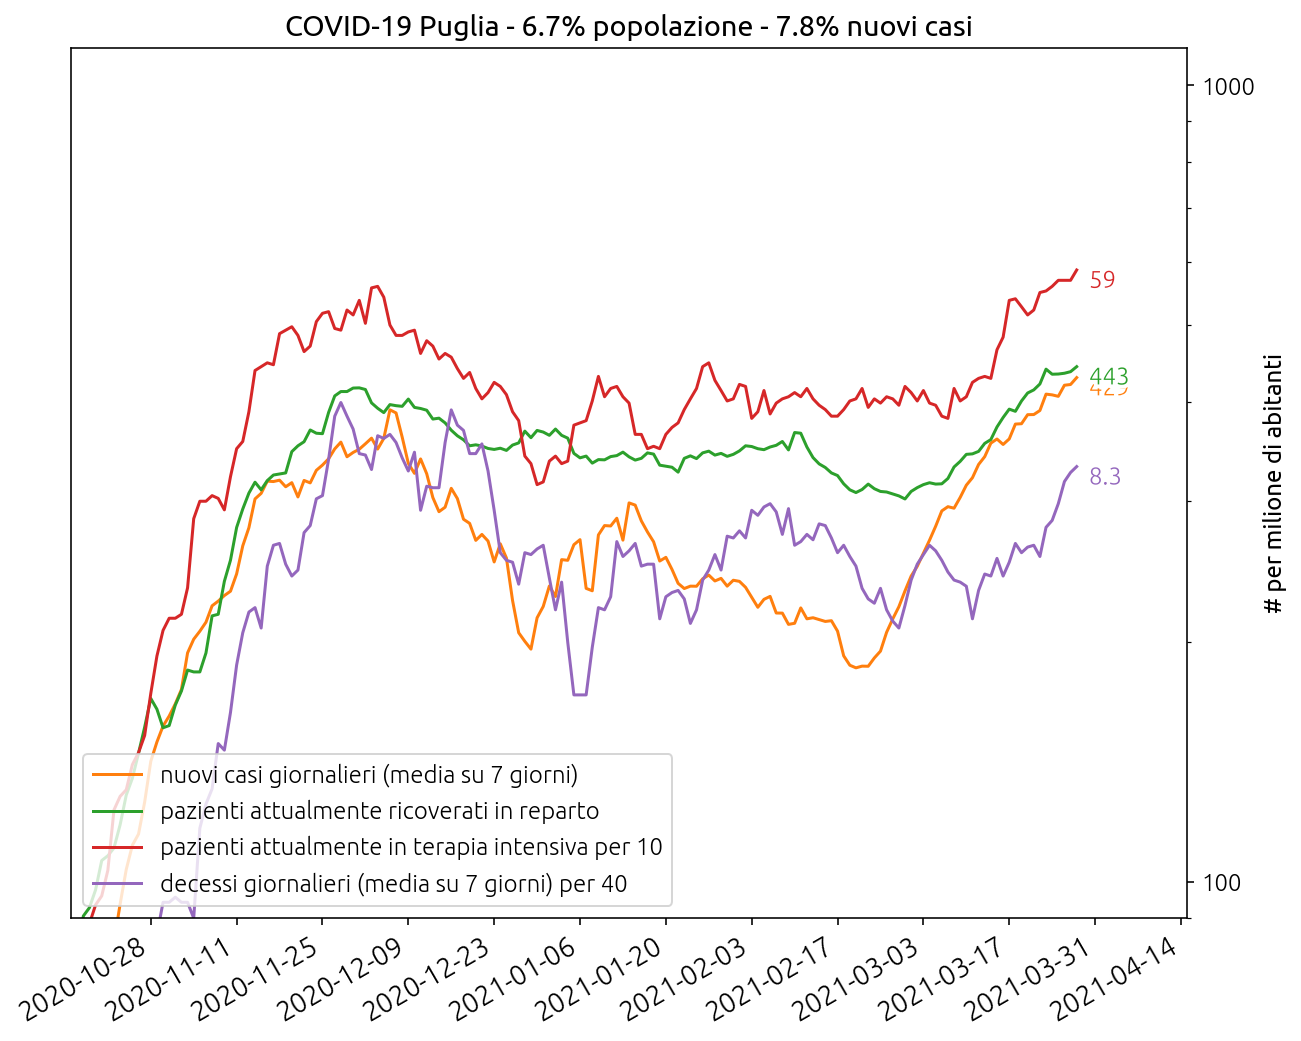

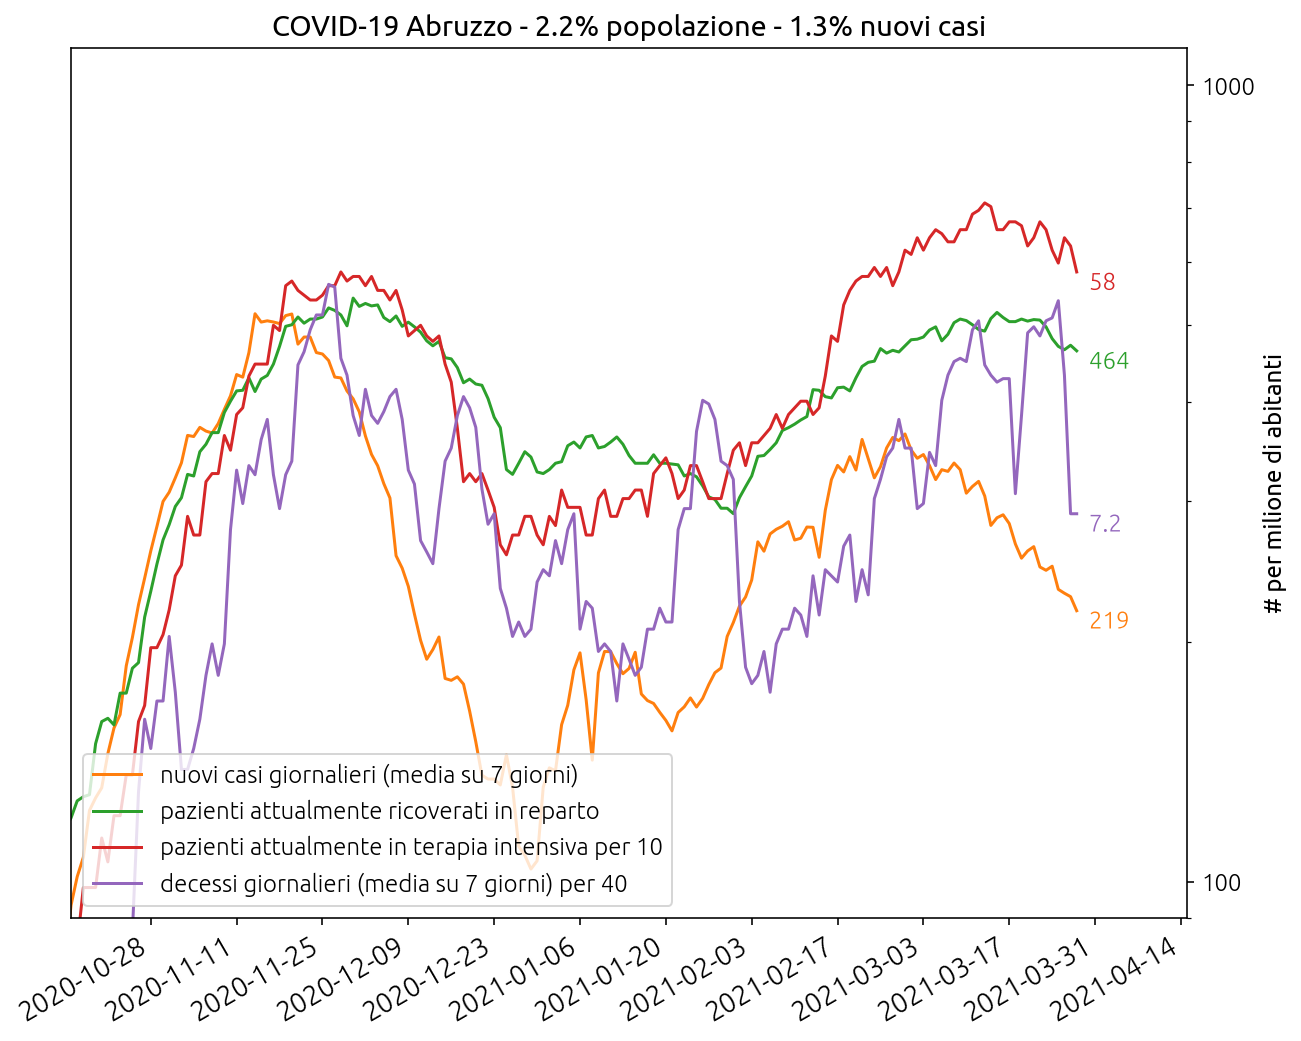

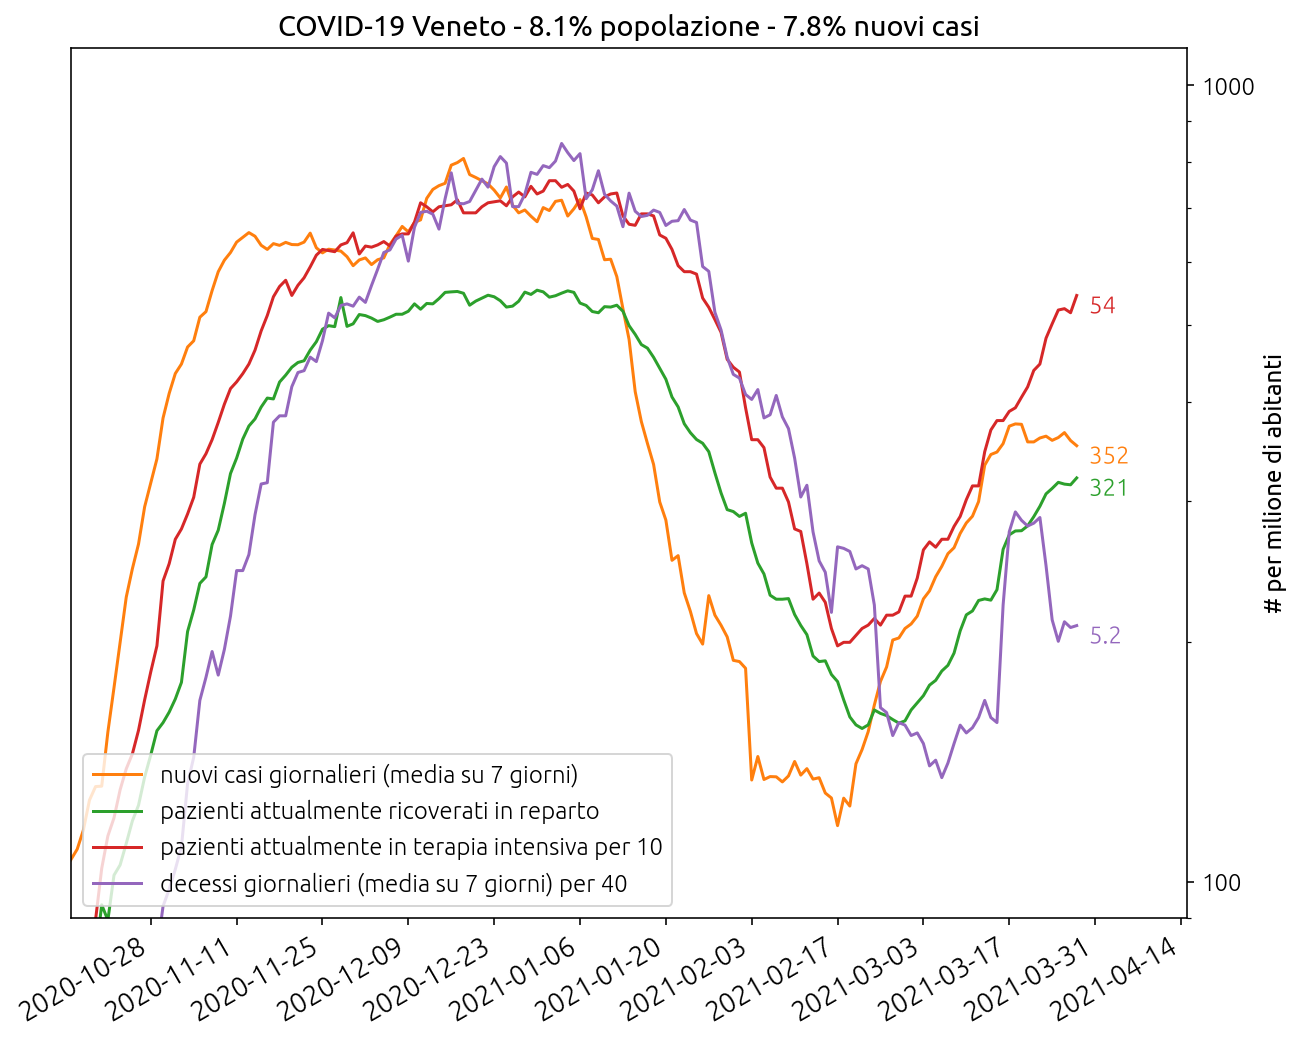

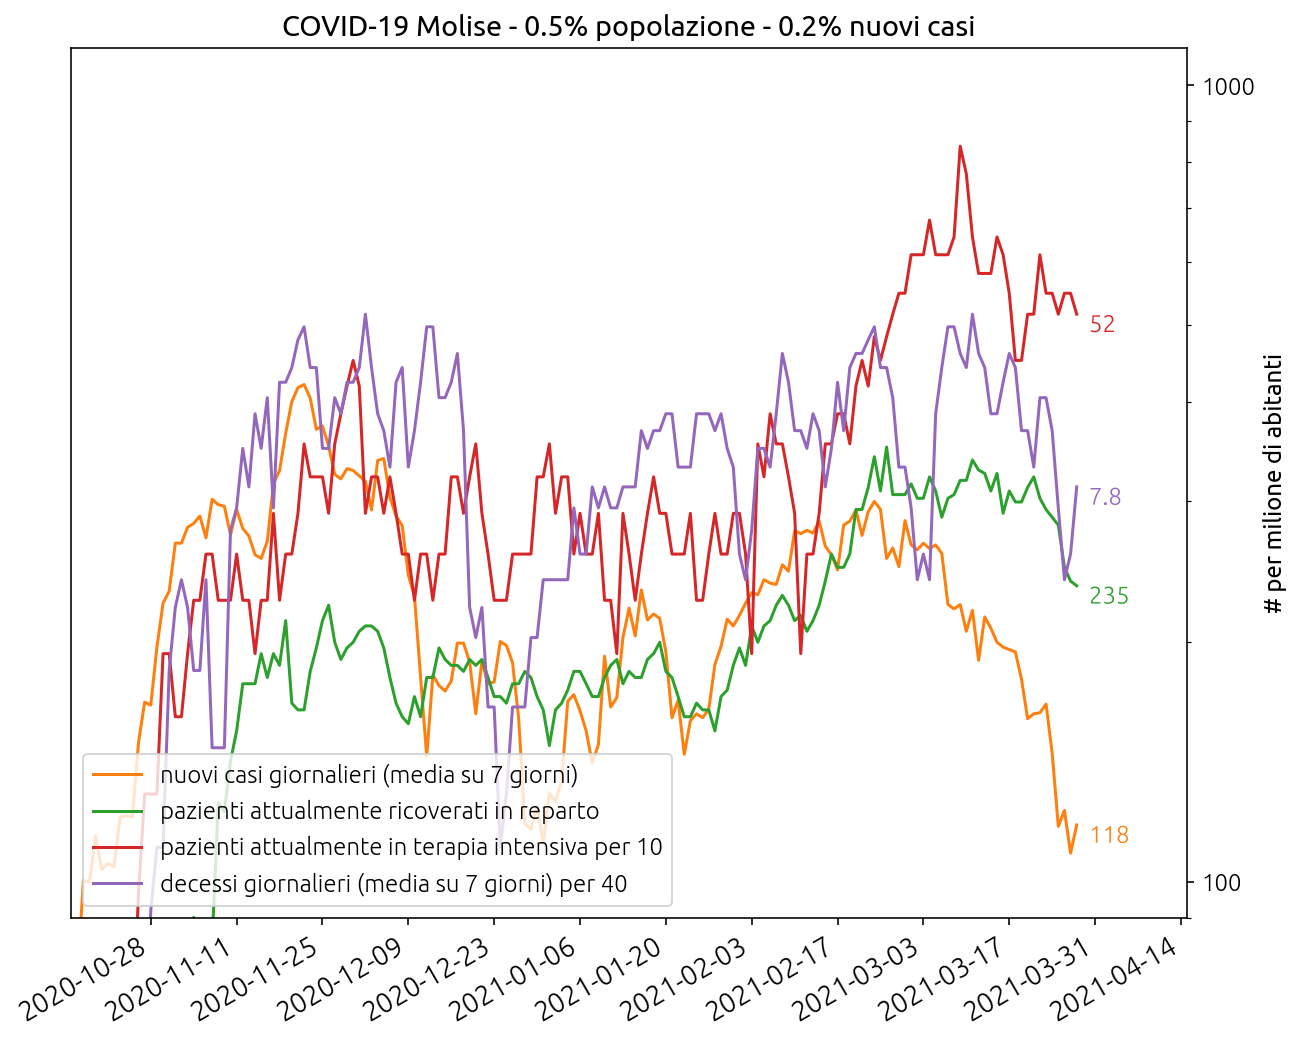

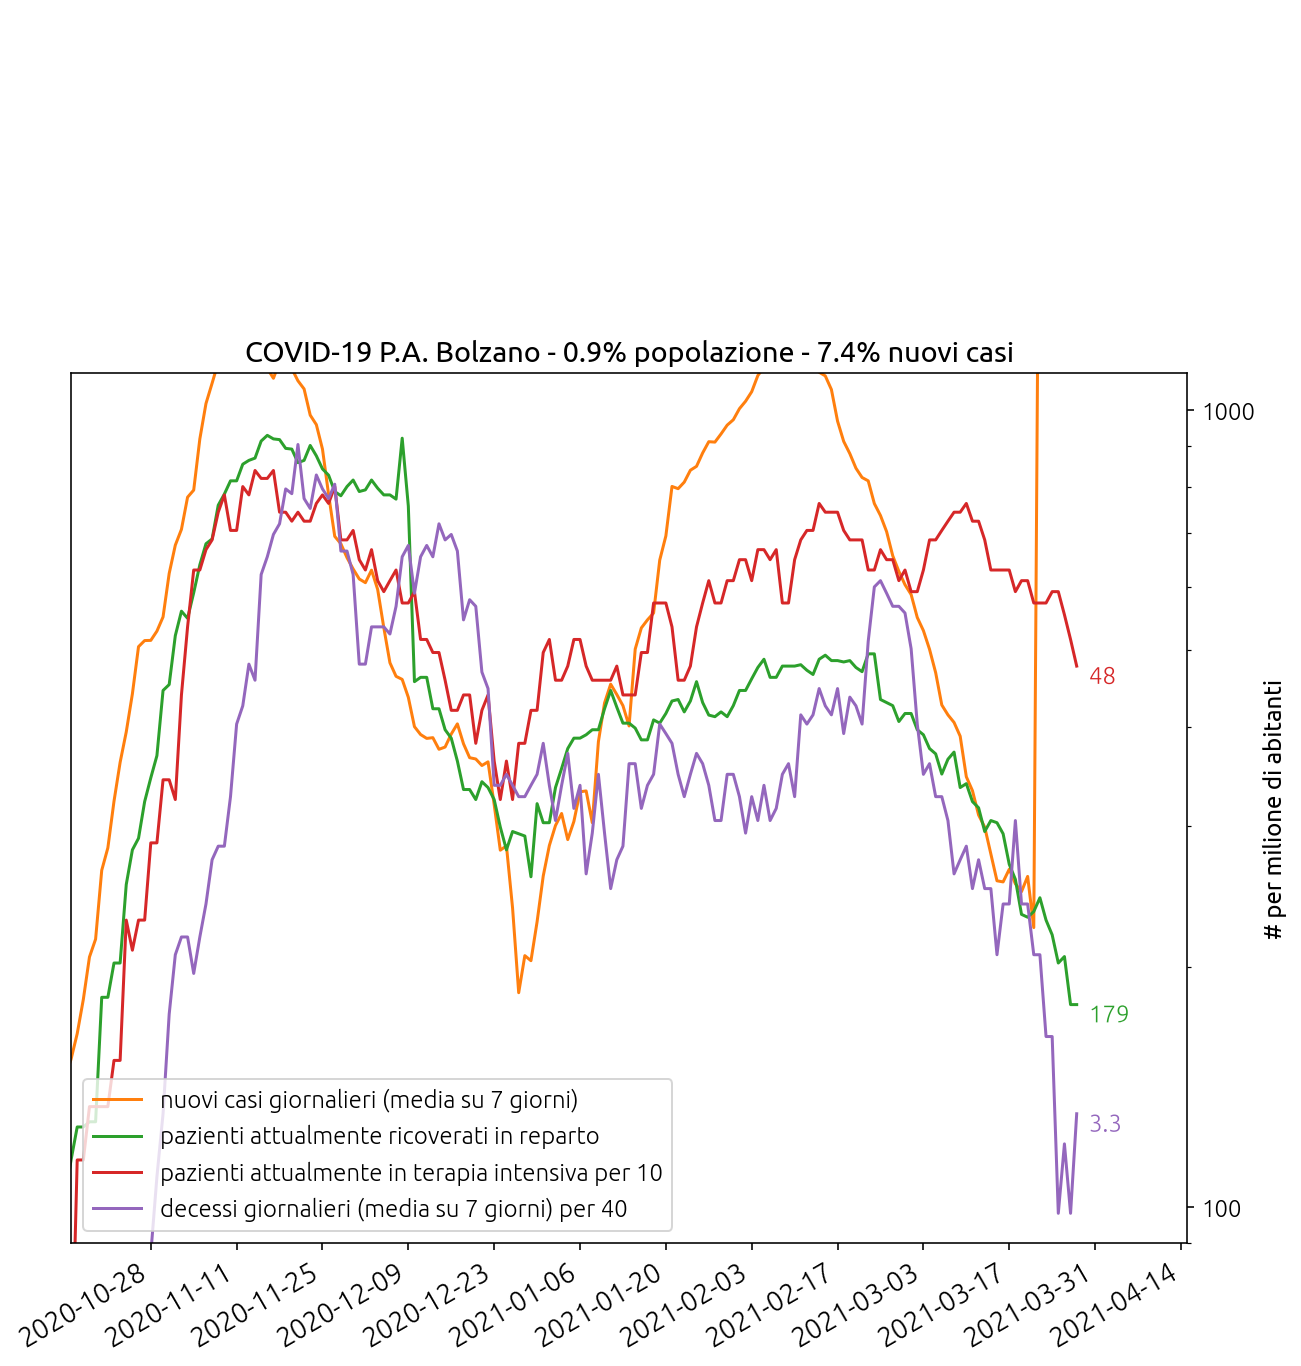

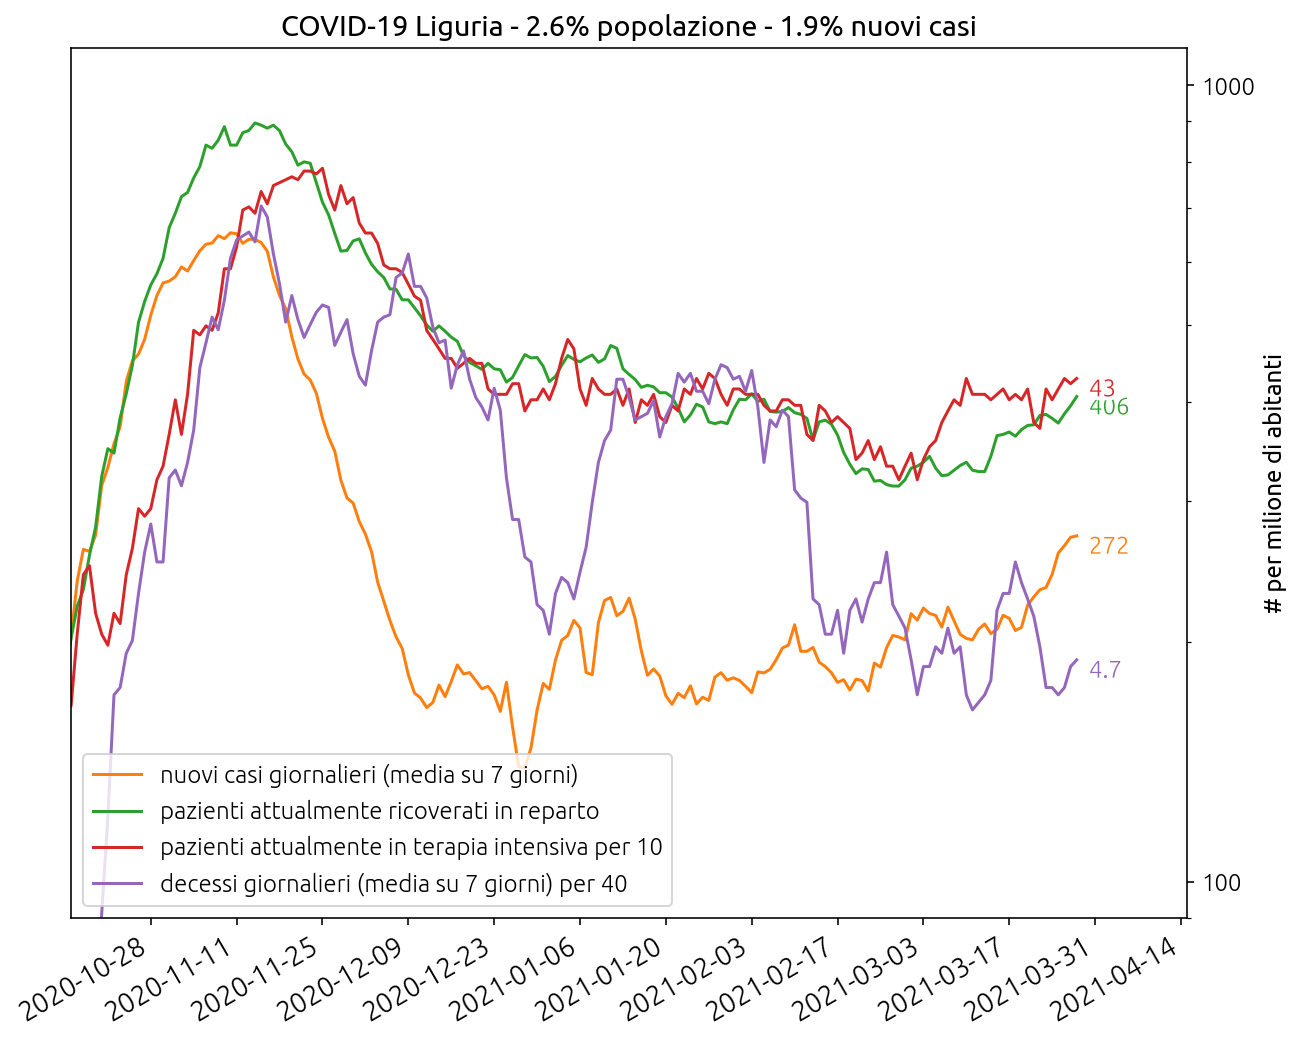

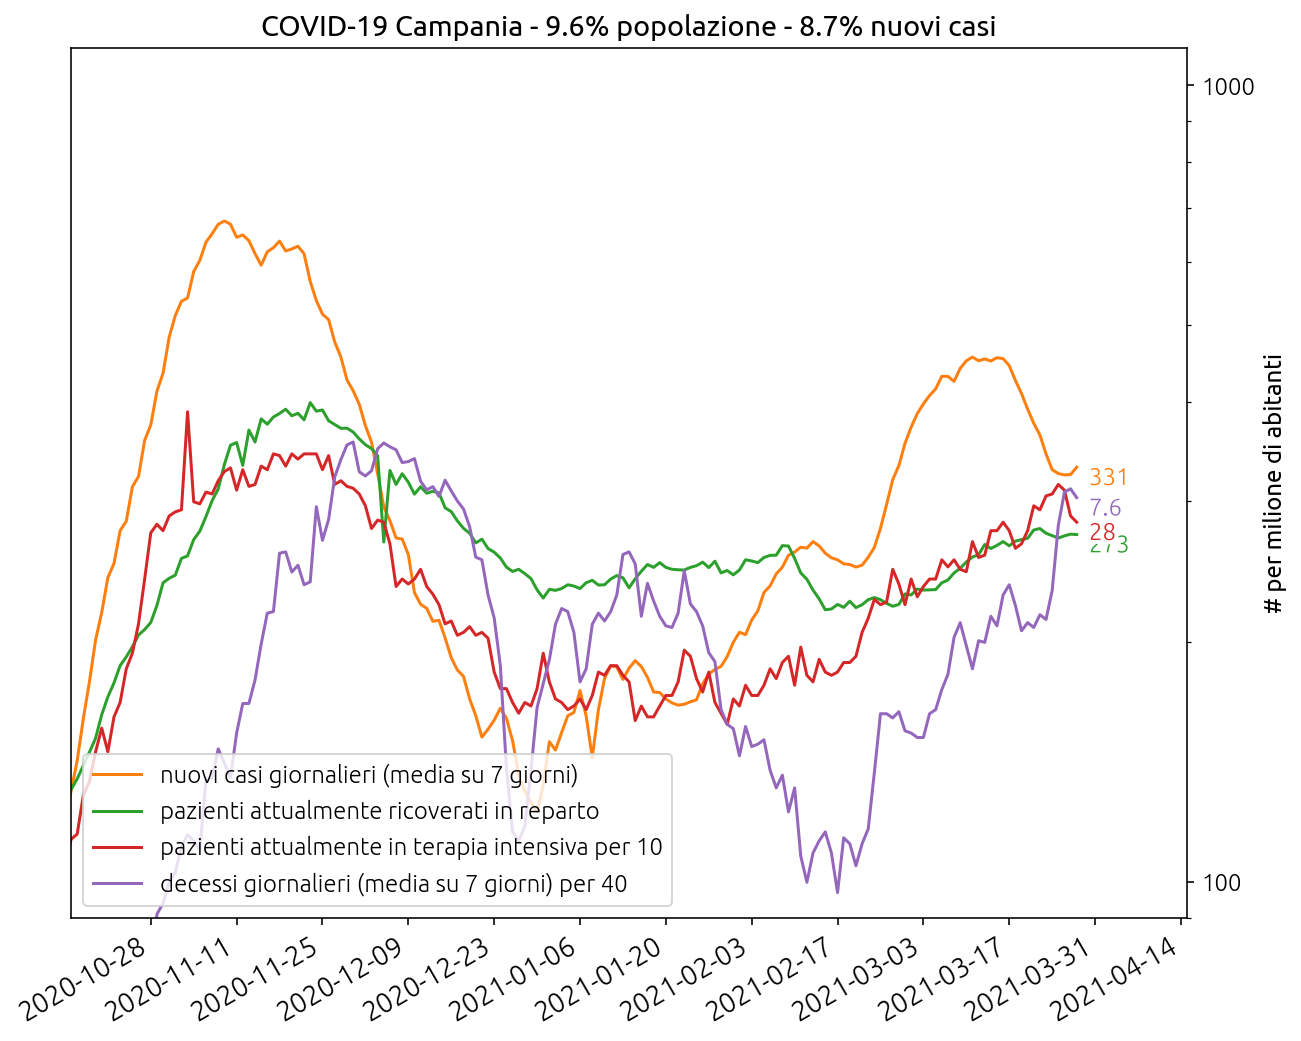

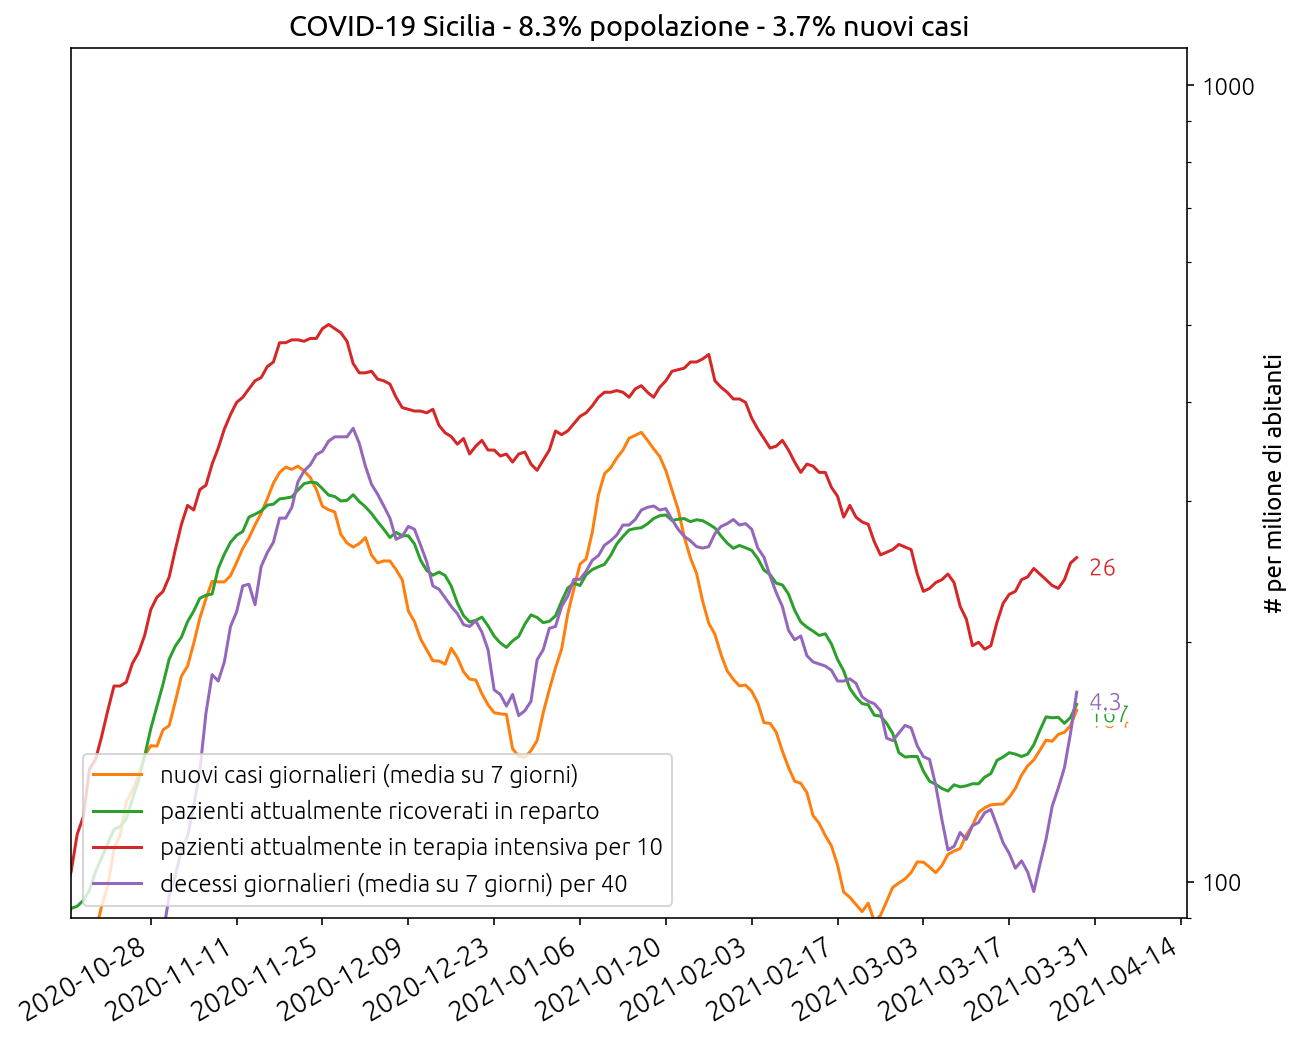

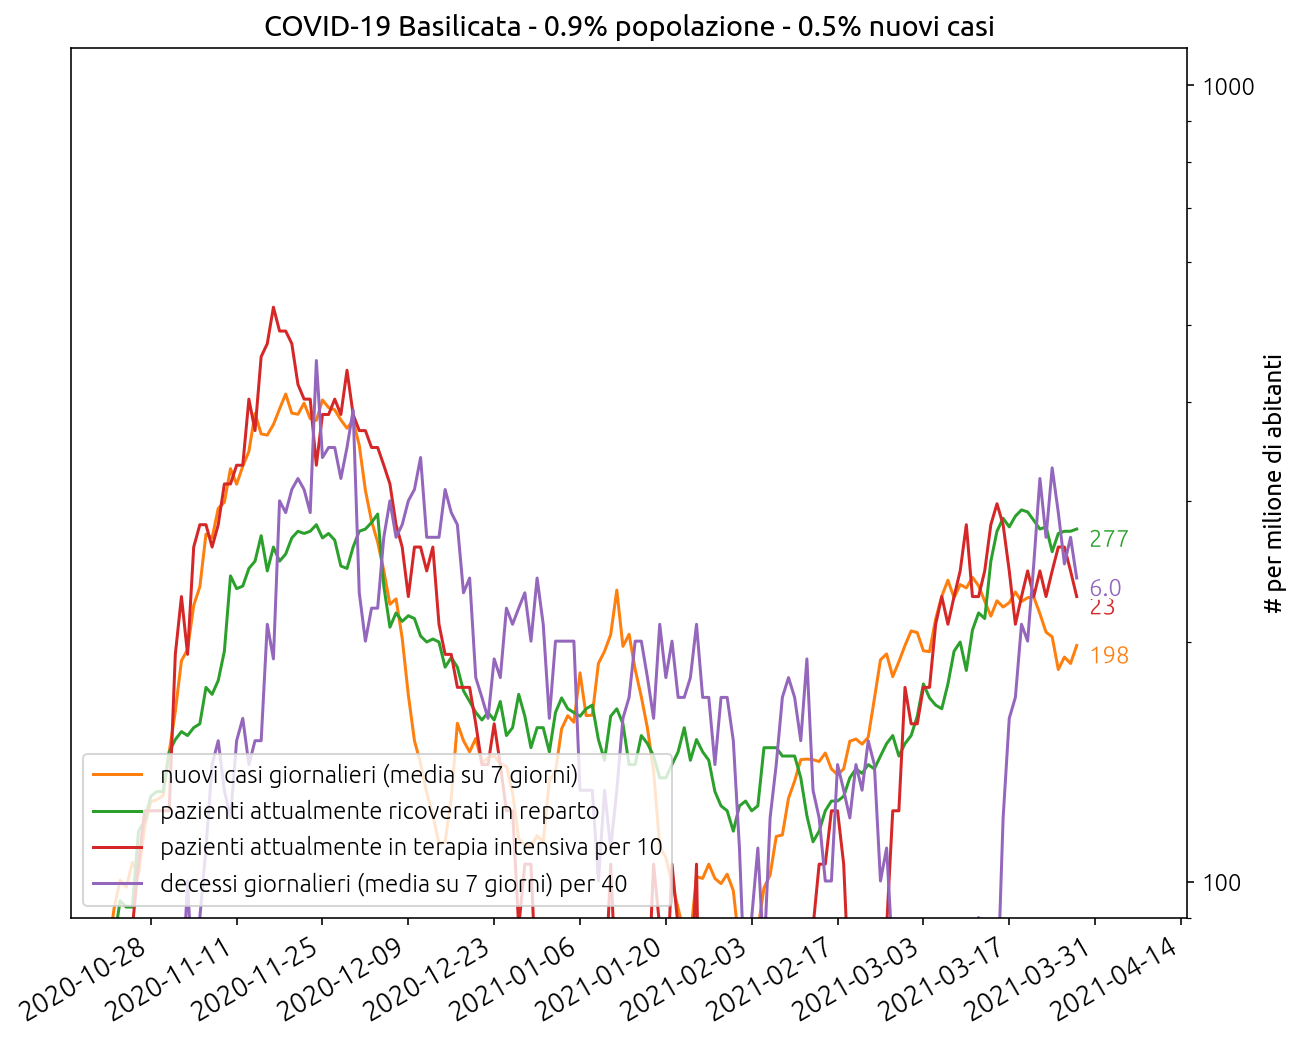

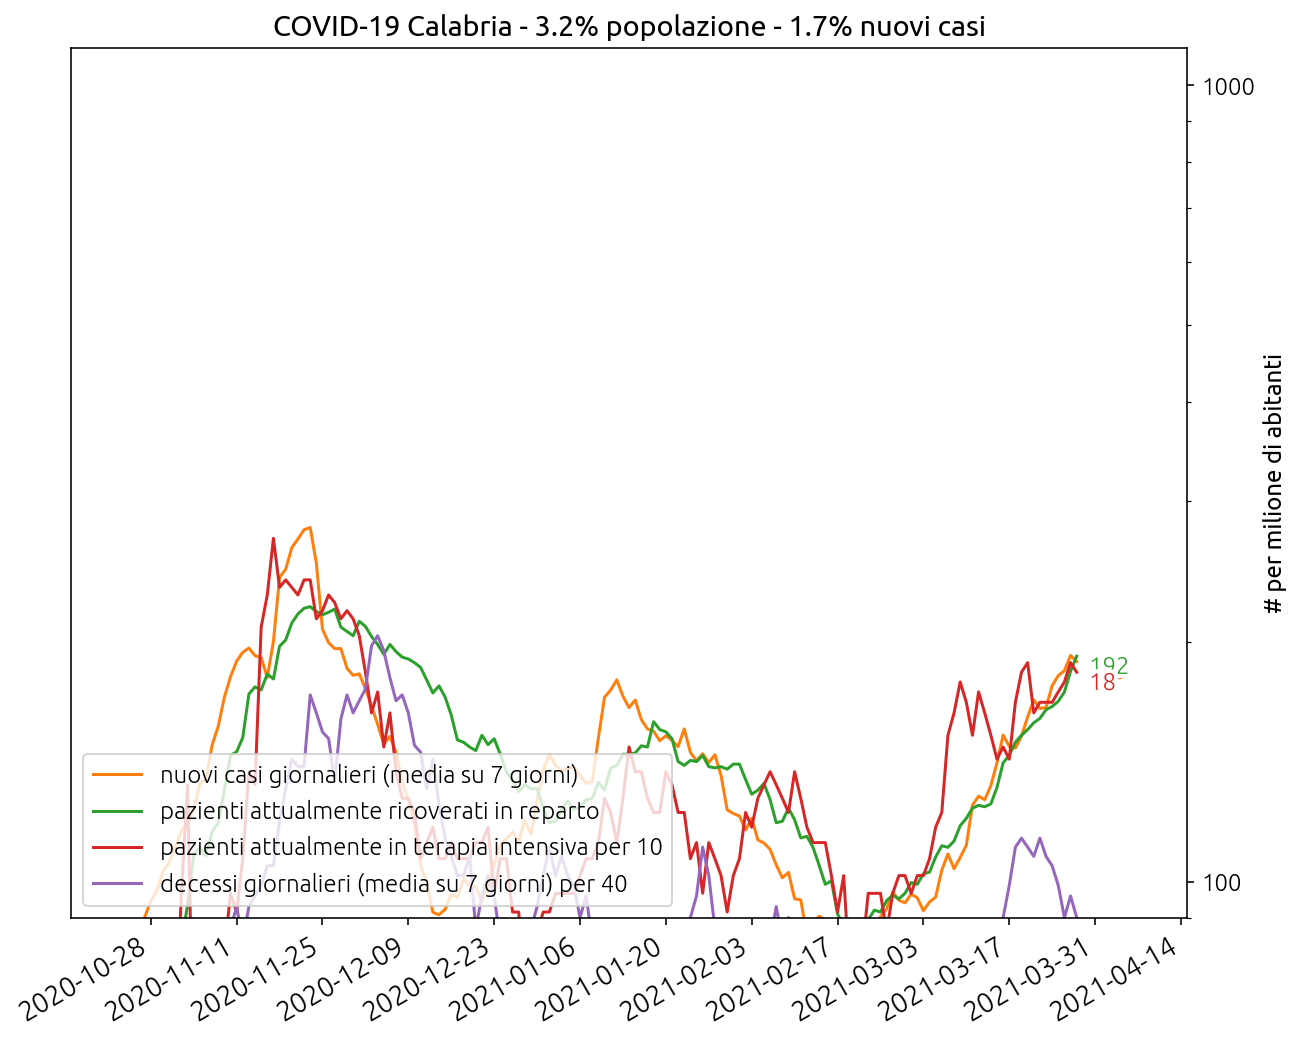

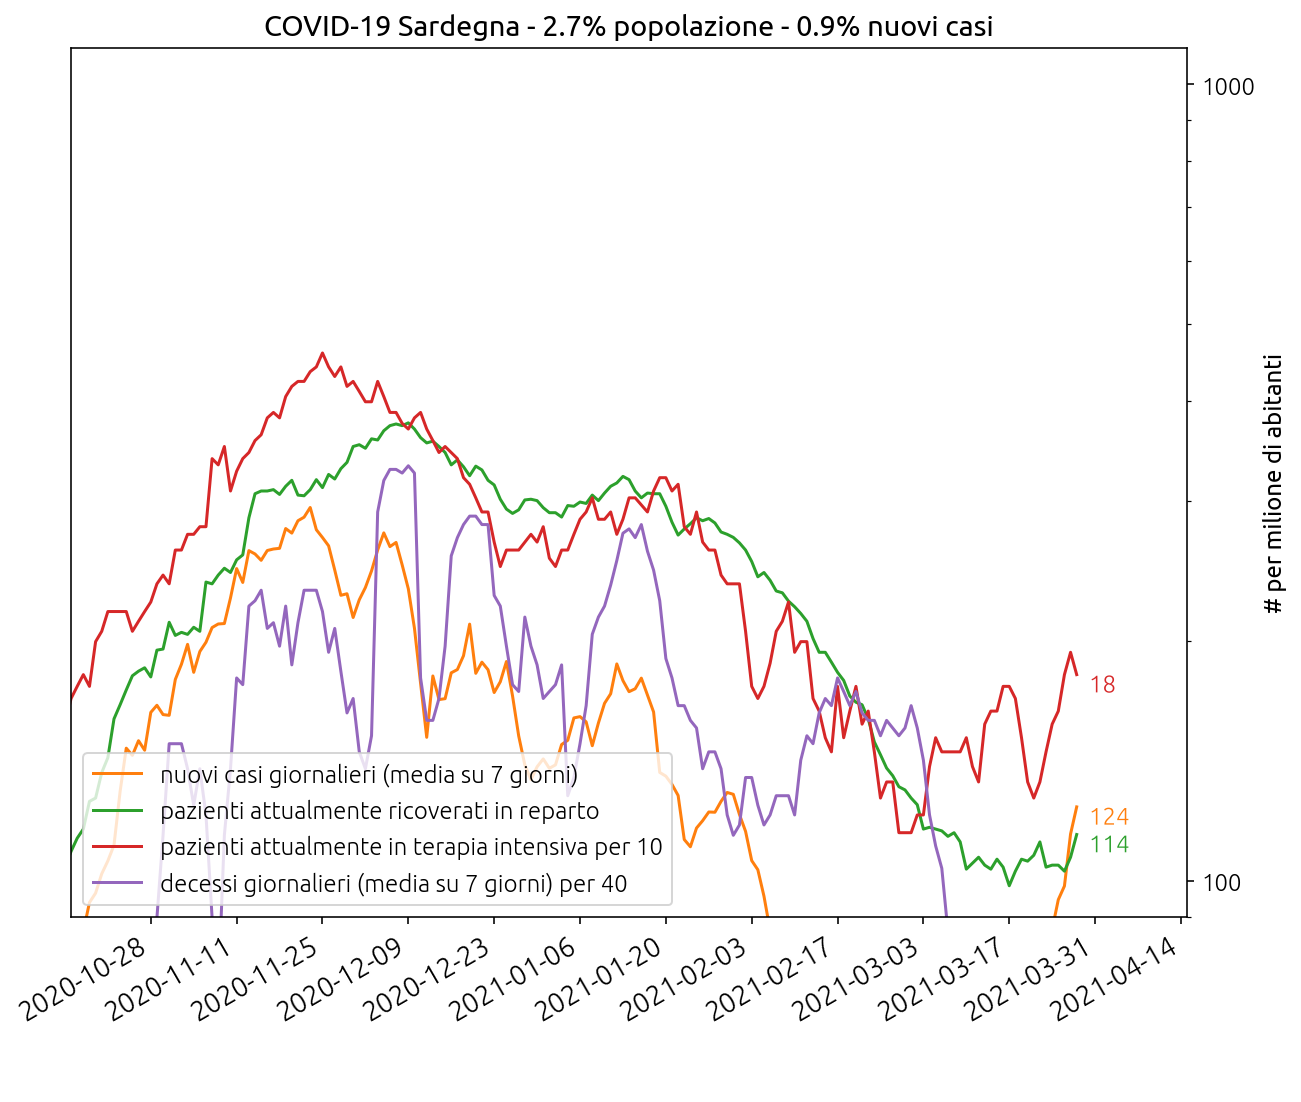

In [432]:
EXTRAPOLATE = (np.datetime64('2020-10-15'), np.datetime64('2021-04-15'))
XLIM = EXTRAPOLATE

SHOW_REGIONS = {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}
# SHOW_REGIONS = {'daily_prevalence7', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (100 * 0.9, 1000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color, ratio, delay in zip(fit_kinds.items(), PALETTE_ONE, [0.1, 1, 1, 10, 40], [0, 0, 0, 0, 0]):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio}'
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, delay=-delay, ratio=1 / ratio, marker=None, date_interval=14, annotate=True)
        #if kind == 'daily_prevalence7':
        #    ax.bar(ds_region.time, ds_region[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        #    ax.bar(ds_region.time[6::7], ds_region[kind[:-1]][6::7], color=color, alpha=0.25)
        #for fit in fitsk:
        #covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)

    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% nuovi casi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='lower left')


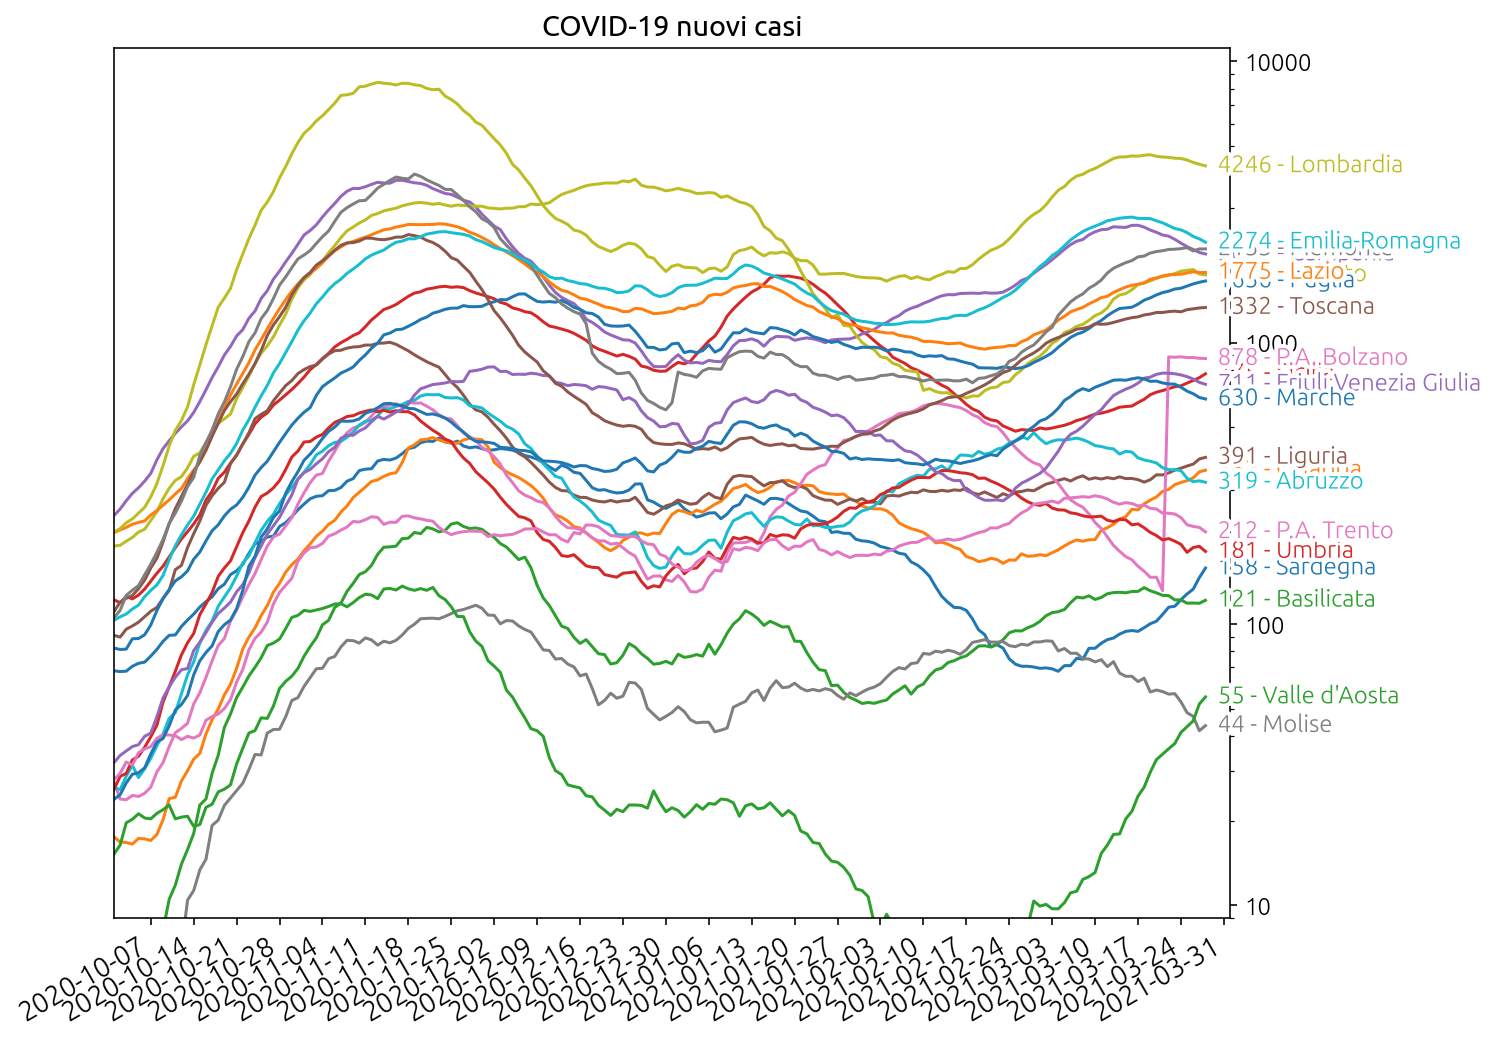

In [429]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'yscale': 'log', 'ylim': (10 * 0.9, 10000 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_confirmed14'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, color=color, marker=None, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 nuovi casi' )
_ = ax.set(xlabel="", ylabel="")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


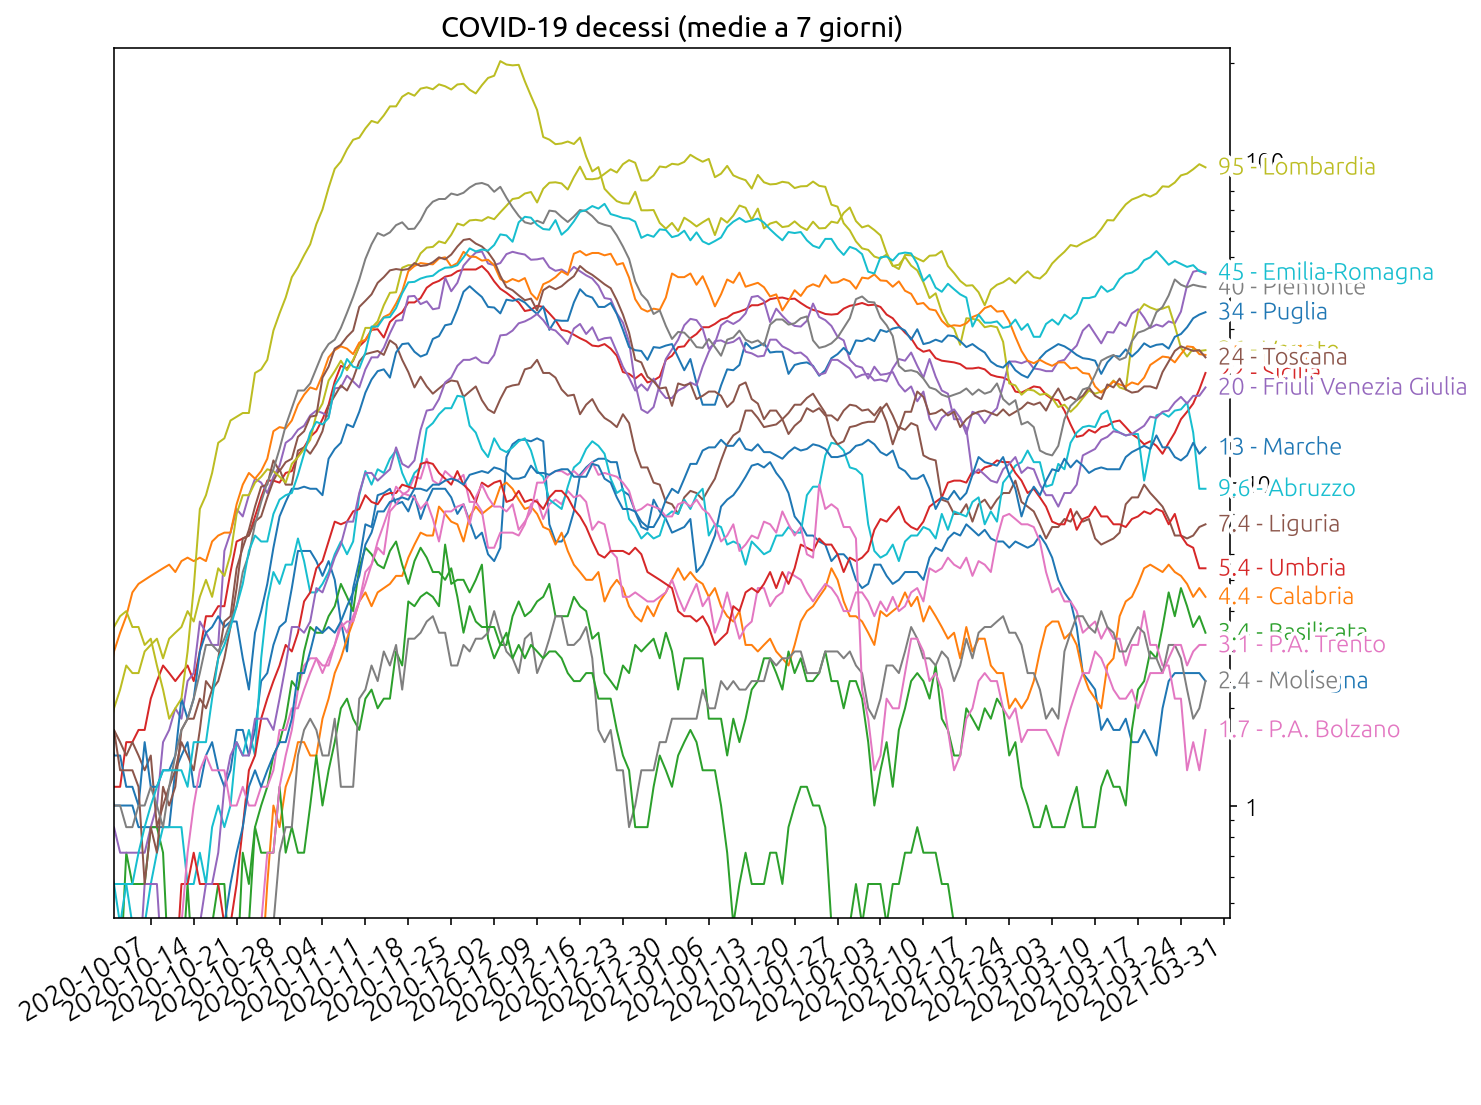

In [430]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'yscale': 'log', 'ylim': (0.5 * 0.9, 200 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_deaths7'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, linewidth=1, color=color, marker=None, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 decessi (medie a 7 giorni)' )
_ = ax.set(xlabel="", ylabel="")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


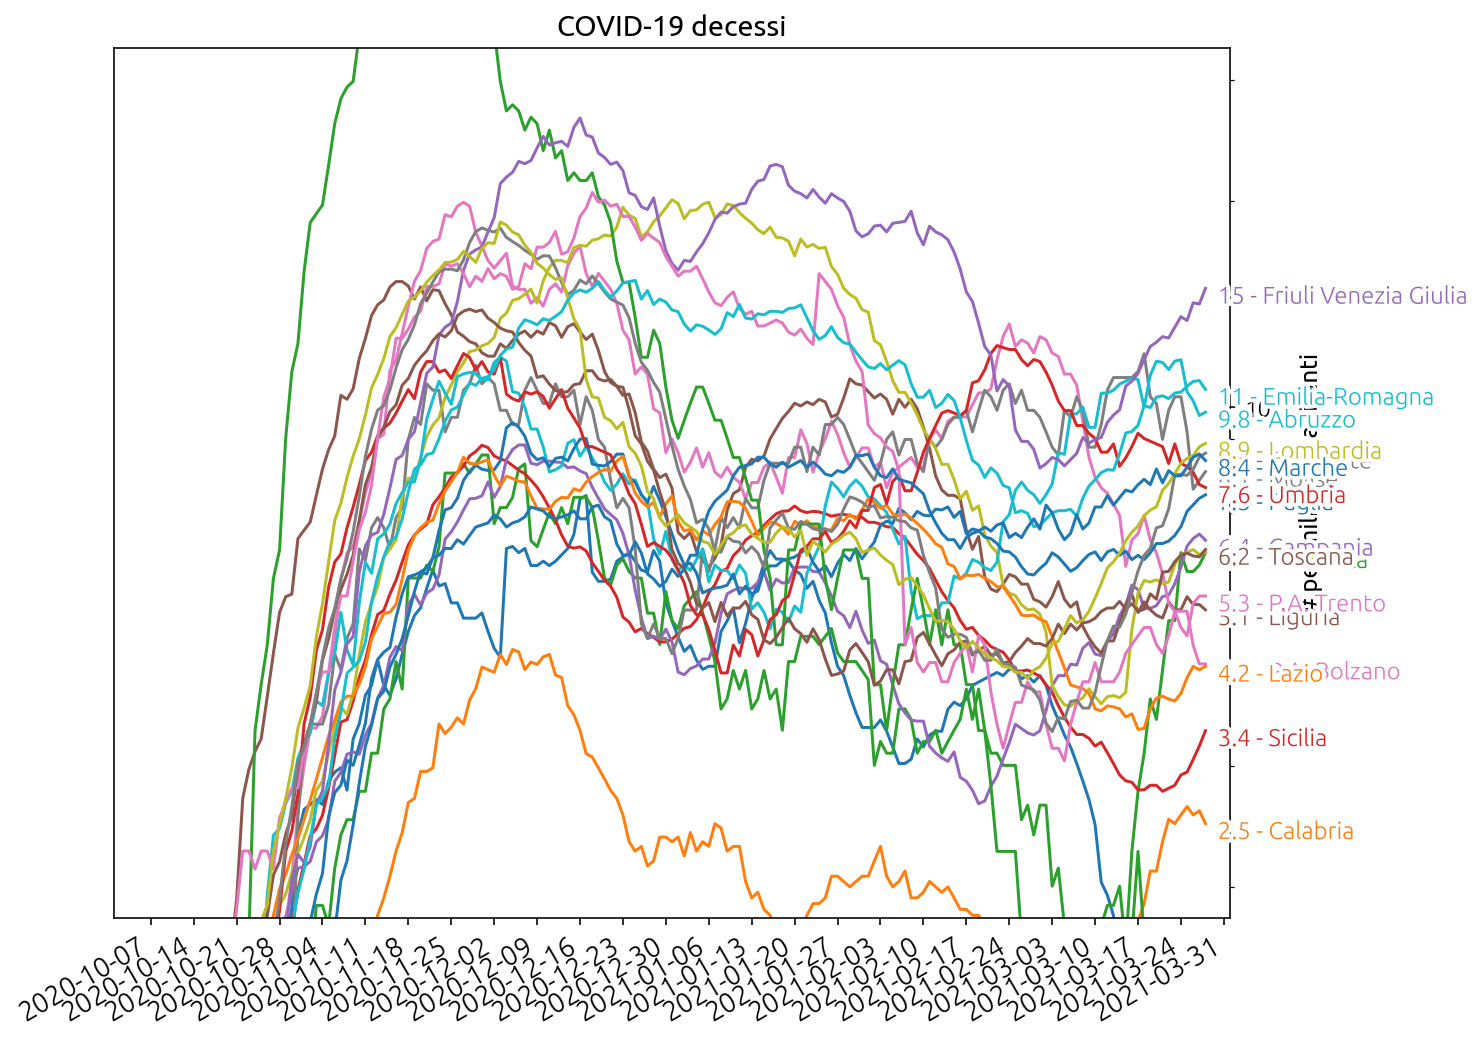

In [431]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM1, 'yscale': 'log', 'ylim': (2 * 0.9, 30 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_mortality14'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, color=color, marker=None, linewidth=1.5, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 decessi' )
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


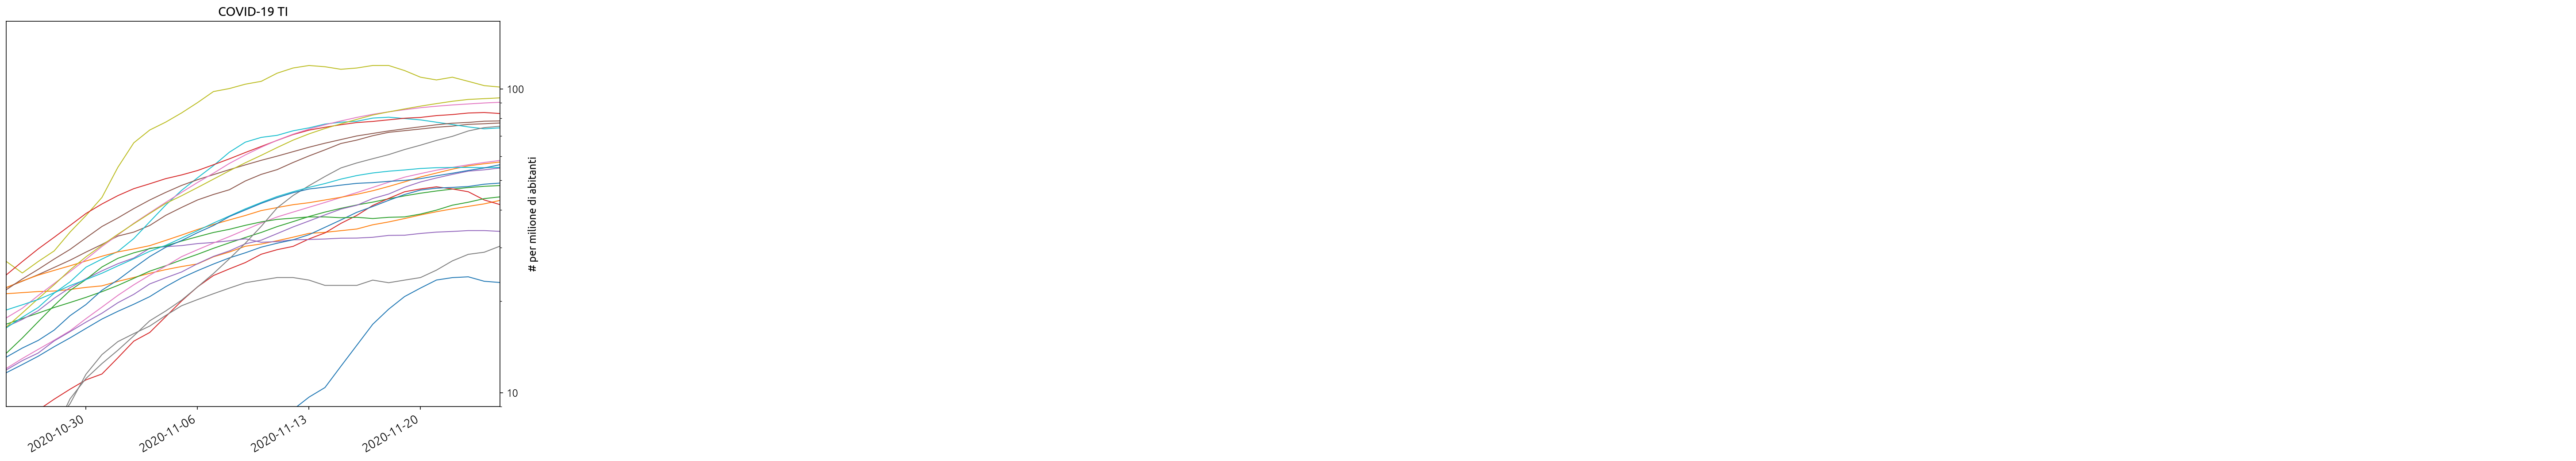

In [409]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-25'), np.datetime64('2020-11-25')), 'yscale': 'log', 'ylim': (10 * 0.9, 150 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'current_critical_pm'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind].rolling({'time': 7}).mean(), label=region, color=color, marker=None, linewidth=1, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 TI' )
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


In [ ]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': (np.datetime64('2020-02-24'), np.datetime64('2021-03-31')), 'ylim': (30, 11000)})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', annotate=True)
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, ratio=1/8, label='Decessi gioralieri per 8', color='tab:purple', date_interval=14, linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe'], marker=None, ratio=15, label='Pazienti ospedalizzati diviso 15', color='tab:green', date_interval=14, linestyle='--')
_ = ax.legend(loc='upper center')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-24')), 'ylim': (100, 10000)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=5, ratio=5.8, label='Nuovi casi (media a 7 giorni) spostati di 5 giorni in avanti e diviso 5.8', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', date_interval=14, annotate=True)
_ = ax.legend(loc='upper left')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
shift = 7
scale = 0.013

color_deaths = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)

_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-21')), 'yscale': 'log', 'ylim': (10, 700)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=shift, ratio=1/scale, label=f'{scale * 100:.2g}% dei nuovi casi di {shift} giorni prima', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], label='Decessi', color=color_deaths, date_interval=7, annotate=True)
covid19.plot.plot_fit(ax, fits['daily_deaths7'][-2], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
covid19.plot.plot_fit(ax, fits['daily_deaths7'][-1], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
_ = ax.legend(loc='upper center')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile (media a 7 giorni)', ylabel='', xlabel='')

In [ ]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed14'], marker=None, delay=0, ratio=35, label='Nuovi casi spostati di 5 giorni in avanti e diviso 42', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe_pm'], marker=None, label='Pazienti ricoverati', color='tab:green', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='# per milione di abitanti', xlabel='')

In [ ]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-05-25'), np.datetime64('2020-11-15')), 'yscale': 'log', 'ylim': (1, 1100)})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, delay=4, ratio=12.5, label='Terapie intensive spostate di 4 giorni in avanti e diviso 12.5', color='tab:red', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi giornalieri (media a 7 giorni)', color='tab:purple', date_interval=14, annotate=True)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
shift = 8
scale = 0.013

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], delay=shift, ratio=1/scale, marker=None, label='Nuovi casi', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Stima denu nuovi casi dai decessi ', color='tab:purple', date_interval=14)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, daily_confirmed_estimate / ds_italy['daily_confirmed7'], marker=None, label='Decessi giornalieri', color='tab:purple', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
SHOW_REGIONS = None  # {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.02 * 0.9, 5000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind]
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, marker=None, date_interval=14, annotate=True)
        for fit in fitsk:
            covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)
    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% positivi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='lower left')


In [ ]:
da = ds_italy['current_critical'][159:]
for i in range(20):
    old = ds_italy['current_critical'][i]
    new = da[(da < old).argmin()]
    print(str(old.time.values)[:10], old.values, ds_italy['daily_deaths'].sel(time=old.time.values).values, str(new.time.values)[:10], new.values)

In [ ]:
daa = ds_italy['current_critical']
for i in range(10):
    try:
        new = da[i * 7 + 3]
    except:
        new = da[-1]
    # print(new, daa.values, (daa > new).values)
    old = daa[(daa <= new).argmin() - 1]
    old1 = daa[(daa <= new).argmin()]
    print(
        str(old.time.values)[:10],
        old.values,
        ds_italy['daily_deaths'].sel(time=old.time.values).values,
        ds_italy['current_severe'].sel(time=old.time.values).values,
        str(new.time.values)[:10],
        new.values,
        ds_italy['daily_deaths'].sel(time=new.time.values).values,
        ds_italy['current_severe'].sel(time=new.time.values).values,
    )

In [ ]:
daa

In [ ]:
a = xr.DataArray(
    [56, 64, 105, 140, 166, 229, 295, 351, 462, 567, 650, 733],
    dims=['time'],
    coords={
        'time': ('time', [np.datetime64(t) for t in ['2020-08-18', '2020-08-25', '2020-09-01', '2020-09-08', '2020-09-15', '2020-09-22', '2020-09-29', '2020-10-06', '2020-10-13', '2020-10-20', '2020-10-27', '2020-11-03']]),
        'old_time': ('time', ['2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09']),
    }
)
a

In [ ]:
# import matplotlib.patheffects as patheffects

f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, da, marker=None, color='tab:red')
# covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'][159:], marker=None, delay=18, ratio=4.6, label='Nuovi casi spostati di 18 giorni in avanti e diviso 4.5', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, a, linestyle='', color='black')
for xp, l in zip(a.time.values, a.old_time.values):
    yp = a.sel(time=xp).values
    ax.annotate(l, (xp - 3 * np.timedelta64(1, 'D'), yp + 10), path_effects=[
                patheffects.Stroke(linewidth=4, foreground='white'),
                patheffects.Normal(),
            ])
ax.set(title='COVID-19 pazienti in terapia intensiva', xlabel='', ylim=(0, 820))

In [ ]:
f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, color='tab:red', date_interval=14)
ax.set(
    ylim=(0, 500),
)
for i in range(10):
    b = ds_italy['current_critical'][i + 2]
    c = da[(da < b).argmin()]
    ax.plot([b.time.values, c.time.values + 3 * np.timedelta64(day=1)], [b.values, b.values], color='tab:red')



In [ ]:
import math

peak_infected_percent = .6
peak_infected = peak_infected_percent * ds_italy.population.values
IFR_base = .006

T_ds_up = [7, 10, 20, 30]

print(f"{peak_infected:,.0f} {peak_infected * IFR_base:,.0f}")

In [ ]:
def Rt(T_d=7, onset_day=5):
    return 2 ** (onset_day / T_d)

print(f"{Rt():.2f}")

In [ ]:
1.64*.8

In [ ]:
2 ** ((t - t_0) / T_d)

T_d / ln(2) * 2 ** ((t - t_0) / T_d) + C

peak_infected = T_d / ln(2) * 2 ** ((t - t_0) / T_d)

ln2(peak_infected * ln(2) / T_d) * T_d = (t - t_0)

In [ ]:
def delta_time(T_d, peak_infected):
    return math.log2(peak_infected * math.log(2) / T_d) * T_d

delta_time(7, peak_infected)

In [ ]:
7 / math.log(2) * 2 ** ((152.5) / 7)

In [ ]:
cumul = 0
T_d = 7
for d in range(500):
    infected = 2 ** ((d + 107.5066) / T_d)
    cumul += infected
    theory = T_d / math.log(2) * 2 ** (d / T_d)
    print(f"{d} {np.datetime64('2020-10-25') + d * DAY:.10s} {infected/2:,.0f} {infected:,.0f} {cumul + 3458000:,.0f}")


In [ ]:
ds_italy['daily_confirmed'].sel(time=slice('2020-06-01')).sum().values * 2 + 3000000

In [ ]:
def approx_tot(T_d):
    for d in range(100, 160):
        print(f"{np.datetime64('2020-07-16') + d * DAY:.10s} {d - 100} {2 ** (d / T_d):,.0f} {T_d / math.log(2) * 2 ** (d / T_d) + 3_500_000:,.0f}")
approx_tot(7)

In [ ]:
from scipy import stats

In [ ]:
x = np.arange(90)

sigma = 1
mu = 10
pd = stats.lognorm.pdf(x, sigma, scale=12)
pd /= sum(pd)
_ = plt.plot(x, pd)

In [ ]:
c = ds_italy['daily_confirmed7']
ds_italy['daily_deaths7'].plot(yscale='log')
plt.plot(ds_italy.time + 12 * DAY, c / 45)
#ds_italy['current_critical'].plot()
plt.plot(ds_italy.time + 3 * DAY, np.convolve(c, pd)[:-89] / 40)